In [1]:
# step 1

# import all the necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import itertools
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statistics
import json
from statsmodels.stats.outliers_influence import variance_inflation_factor


# importing xgboost for fun
import xgboost as xgb
from xgboost import XGBRegressor


# turns a csv file into a pandas dataframe
data = pd.read_csv("class_final_proportion.csv")

print(data)
print("length of raw csv file:", len(data))

      party  seats sq_cabinet  sq_pm  election_year  base  miw_new   banzhaf  \
0        MP     16          0    0.0           1998    16        1  0.054545   
1        SJ     25          1    1.0           2007    25        2  0.500000   
2     GRENG      5          0    0.0           1994     5        1  0.076923   
3     GRAEN      6          0    0.0           1999     6        1  0.166667   
4       CSV     21          1    1.0           1994    21        3  0.384615   
..      ...    ...        ...    ...            ...   ...      ...       ...   
652  GRUENE      8          0    0.0           1986     8        0  0.000000   
653     SPO     71          1    1.0           1995    71        1  0.333333   
654    LSAP     17          1    0.0           1994    17        2  0.230769   
655  CDS-PP     15          0    0.0           1999    15        1  0.027778   
656  GRUENE      9          0    0.0           1995     9        0  0.000000   

      shapley     splus  ... country_du

In [2]:
# step 2

# for updated_data dataframe, drop the data observations that are missing the target variable ('cabinet_proportion')
# alternatively run .info() to get idea of missingness if I'm picking a DV

updated_data = data.dropna(subset=['cabinet_proportion'])
print(updated_data.head()) # prints the first few rows
print("# of obs with target variable:", len(updated_data))

   party  seats sq_cabinet  sq_pm  election_year  base  miw_new   banzhaf  \
0     MP     16          0    0.0           1998    16        1  0.054545   
1     SJ     25          1    1.0           2007    25        2  0.500000   
2  GRENG      5          0    0.0           1994     5        1  0.076923   
3  GRAEN      6          0    0.0           1999     6        1  0.166667   
4    CSV     21          1    1.0           1994    21        3  0.384615   

    shapley     splus  ... country_dummy5  country_dummy6  country_dummy7  \
0  0.052381  0.037114  ...              0               0               0   
1  0.500000  0.458311  ...              0               0               1   
2  0.066667  0.051242  ...              0               0               0   
3  0.166667  0.121258  ...              0               0               1   
4  0.400000  0.379442  ...              0               0               0   

  country_dummy8  country_dummy9  country_dummy10  country_dummy11  \
0   

In [3]:
# the raw csv file had a length of 657, and no observations were missing the DV. yay!

In [4]:
# step 3

# table to get info (how many null values, data types, etc.) for dataframe

# get an idea of the # of non-null entries and the datatypes
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   party               657 non-null    object 
 1   seats               657 non-null    int64  
 2   sq_cabinet          657 non-null    object 
 3   sq_pm               644 non-null    float64
 4   election_year       657 non-null    int64  
 5   base                657 non-null    int64  
 6   miw_new             657 non-null    int64  
 7   banzhaf             657 non-null    float64
 8   shapley             657 non-null    float64
 9   splus               657 non-null    float64
 10  country             657 non-null    object 
 11  cabinet_id          657 non-null    int64  
 12  party_id            657 non-null    int64  
 13  cabinet_name        657 non-null    object 
 14  caretaker           657 non-null    int64  
 15  cabinet_party       657 non-null    int64  
 16  prime_mi

In [5]:
# step 4

# drop columns that are object/string-data types, because we can't feed those into a decision tree later
# drop the columns that were missing too much data (my threshold was more than 50% - I was trying to balance not 
# having to drop too many rows with NaN values, and 
# my line of reasoning was if an IV had too much missingness, I didn't want to impute and it was probably 
# not a super significant measurement especially 
# if a lot of observations didn't have it/the European democracy didn't bother measuring it) 

columns_to_drop = ['coalition_total',    # colation_total is missing for 424 of the total 657 observations
                   'party_name',         # object/string type
                   'party',              # object/string type
                   'country',            # object/string type
                   'cabinet_name',       # object/string type
                   'party_name_english', # object/string type
                   'election_date',      # object/string type
                   'start_date']         # object/string type     

updated_data.drop(columns=columns_to_drop, axis=1, inplace=True)

print(updated_data)
print("# obs with string or object data-type IVs dropped/signif missingness columns dropped/:", len(updated_data))

# .dropna for rows with remaining missingness
updated_data=updated_data.dropna()
updated_data.info()
print(updated_data)


     seats sq_cabinet  sq_pm  election_year  base  miw_new   banzhaf  \
0       16          0    0.0           1998    16        1  0.054545   
1       25          1    1.0           2007    25        2  0.500000   
2        5          0    0.0           1994     5        1  0.076923   
3        6          0    0.0           1999     6        1  0.166667   
4       21          1    1.0           1994    21        3  0.384615   
..     ...        ...    ...            ...   ...      ...       ...   
652      8          0    0.0           1986     8        0  0.000000   
653     71          1    1.0           1995    71        1  0.333333   
654     17          1    0.0           1994    17        2  0.230769   
655     15          0    0.0           1999    15        1  0.027778   
656      9          0    0.0           1995     9        0  0.000000   

      shapley     splus  cabinet_id  ...  country_dummy4  country_dummy5  \
0    0.052381  0.037114         503  ...               0   

In [6]:
# step 5

# print summary statistics

# summary statistics on variables as a dictionary
sampleValuesDict = {}
updated_data.pop('sq_cabinet') # not sure why the .info table showed sq_cabinet as an object type, but I... 
# ...had to pop it out here in order for this cell to run
for column_name, column_data in updated_data.items():
    mean = column_data.mean()
    std = column_data.std()
    min = column_data.min()
    twentyfivepercentile = column_data.quantile(0.25)
    fiftypercentile = column_data.quantile(0.50)
    seventyfivepercentile = column_data.quantile(0.75)
    max = column_data.max()
    var = statistics.variance(column_data)
    sampleValuesDict[column_name] = {"Mean":mean, "STD":std, "Min":min, "25%":twentyfivepercentile, 
                                     "50%":fiftypercentile, "75%":seventyfivepercentile, "Max":max, "Variance": var}

# prints the dictionary of summary stats! and indent, so it looks nice
print(json.dumps(sampleValuesDict, indent=7))

#print(updated_data.items())
updated_data1 = updated_data.copy() # made a deep copy of this dataframe in case I needed it later.

{
       "seats": {
              "Mean": 39.953804347826086,
              "STD": 51.48593667071424,
              "Min": 1,
              "25%": 11.0,
              "50%": 23.0,
              "75%": 47.25,
              "Max": 319,
              "Variance": 2650.8016748607984
       },
       "sq_pm": {
              "Mean": 0.17119565217391305,
              "STD": 0.37719267734058143,
              "Min": 0.0,
              "25%": 0.0,
              "50%": 0.0,
              "75%": 0.0,
              "Max": 1.0,
              "Variance": 0.14227431583935551
       },
       "election_year": {
              "Mean": 1997.7065217391305,
              "STD": 7.516431473257038,
              "Min": 1986,
              "25%": 1991.0,
              "50%": 1998.0,
              "75%": 2003.5,
              "Max": 2011,
              "Variance": 56.49674209216917
       },
       "base": {
              "Mean": 39.953804347826086,
              "STD": 51.48593667071424,
              "Min":

In [7]:
# step 6

# after looking at the summary statistics for all of my potential feature variables, I decided to drop 'A' aka the 
# indicator for whether there was a single winning party, but because that potential IV had 0 variance (and we 
# want our x's in a poly regression to have variance). ie column for IV 'A' was basically a column of zeroes
# note to self: updated_data1 is the same as updated_data, except it doesn't have column 'A'

columns_to_drop = ['A']         # potential IV that had no variance, so it was dropped and is no longer a potential IV  

updated_data.drop(columns=columns_to_drop, axis=1, inplace=True)

print(updated_data)
#print(len(updated_data))

     seats  sq_pm  election_year  base  miw_new   banzhaf   shapley     splus  \
5      245    1.0           1998   245        1  0.166667  0.166667  0.144816   
6       55    0.0           2002    55        1  0.333333  0.333333  0.252555   
8       52    0.0           1994    52        1  0.333333  0.333333  0.314240   
9       22    0.0           1989    22        2  0.153846  0.166667  0.148417   
13      41    0.0           1995    41        1  0.333333  0.333333  0.302558   
..     ...    ...            ...   ...      ...       ...       ...       ...   
645     46    0.0           1999    46        9  0.259091  0.244048  0.261002   
646     67    0.0           1993    67        4  0.461538  0.466667  0.500490   
647     23    0.0           2005    23        2  0.127273  0.119048  0.139729   
648     61    0.0           2005    61        5  0.418182  0.419048  0.438232   
653     71    1.0           1995    71        1  0.333333  0.333333  0.353853   

     cabinet_id  party_id  

/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


array([[<Axes: title={'center': 'country_dummy13'}>]], dtype=object)

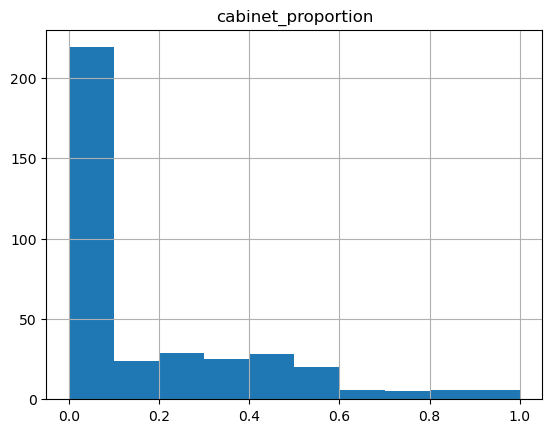

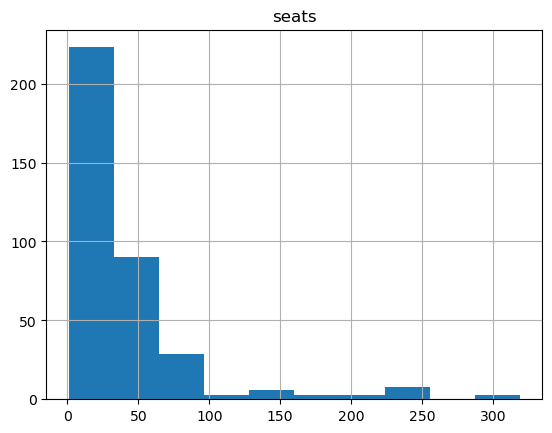

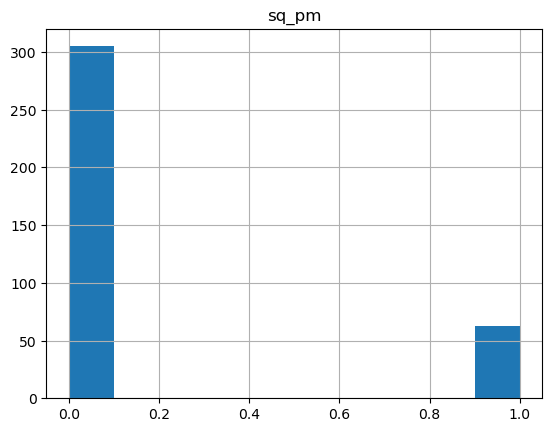

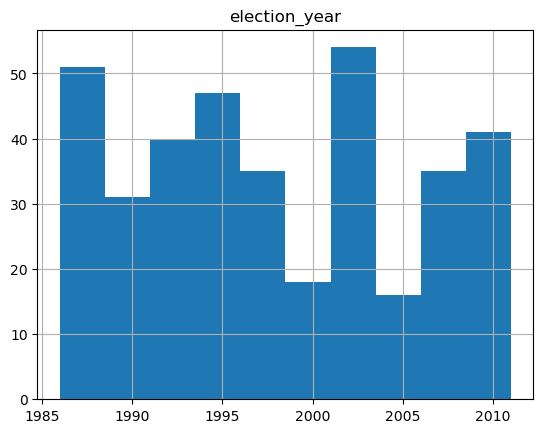

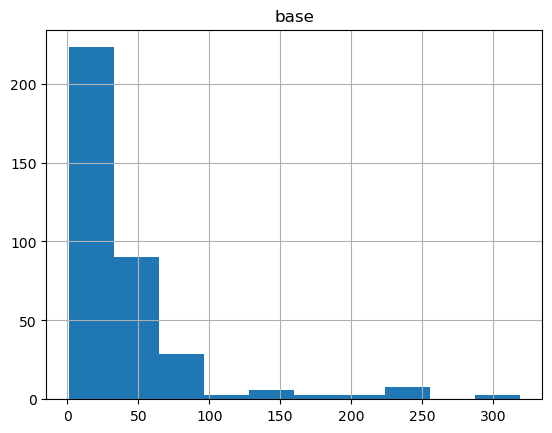

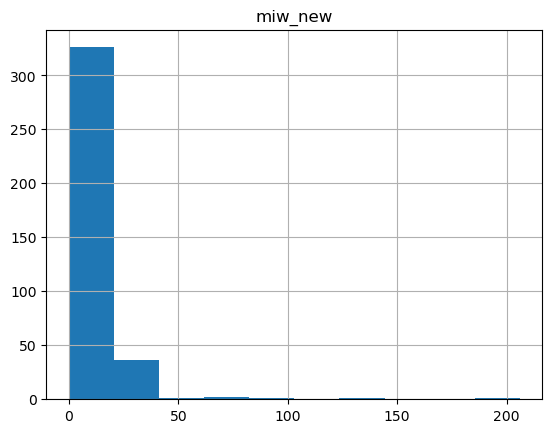

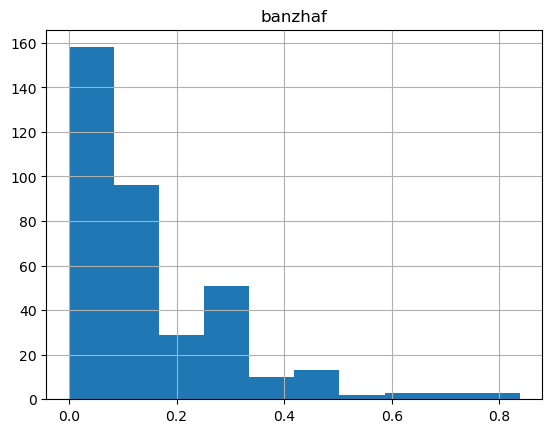

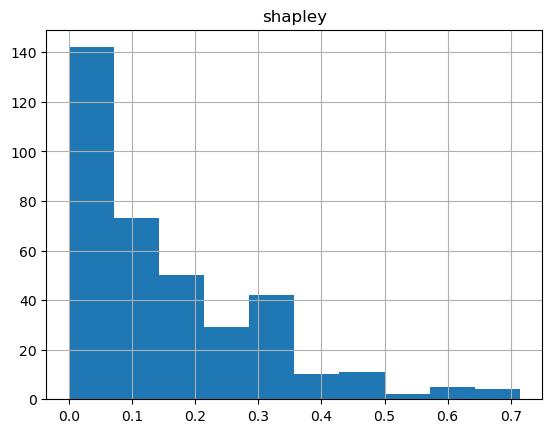

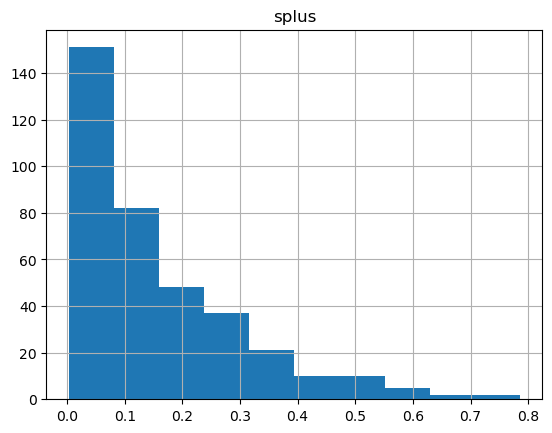

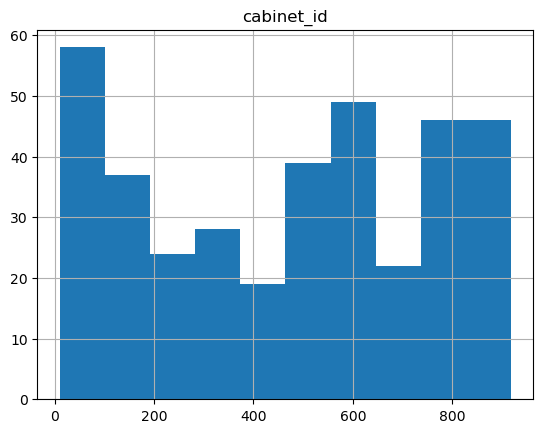

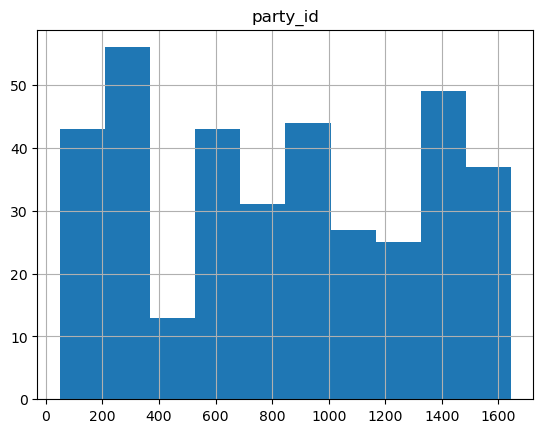

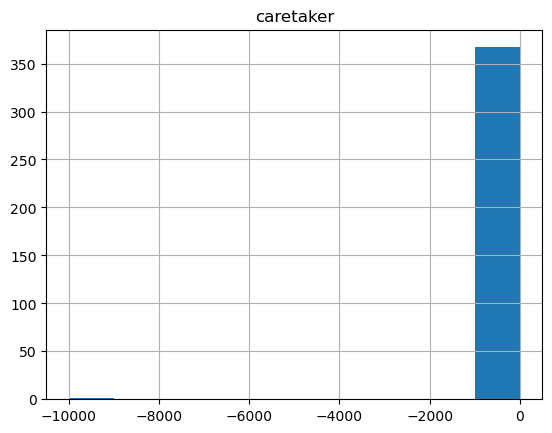

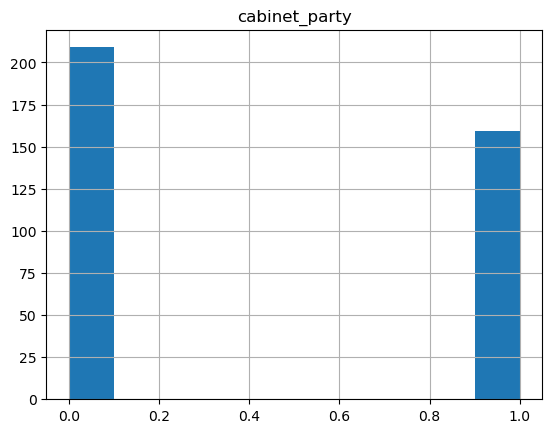

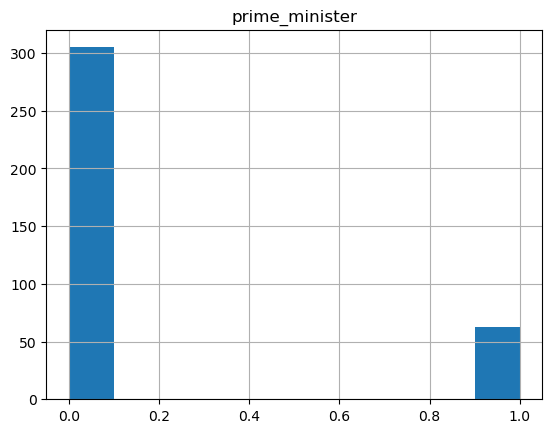

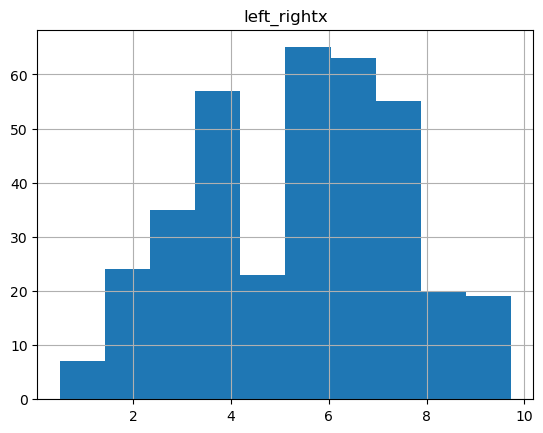

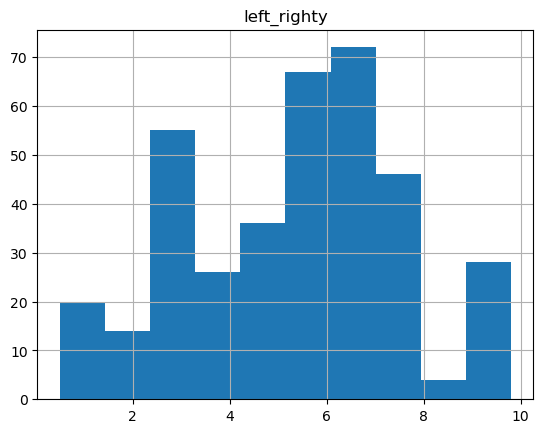

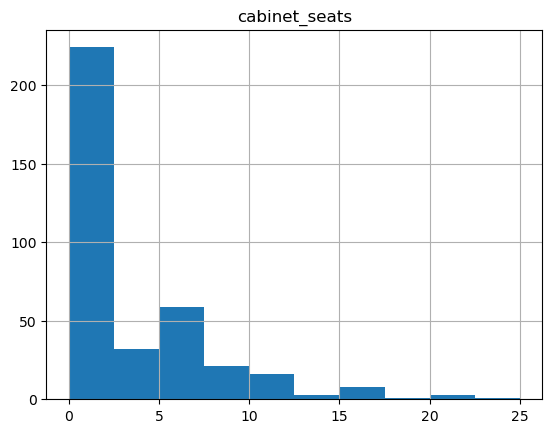

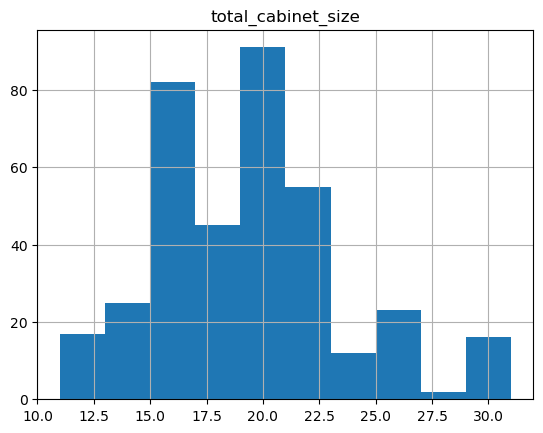

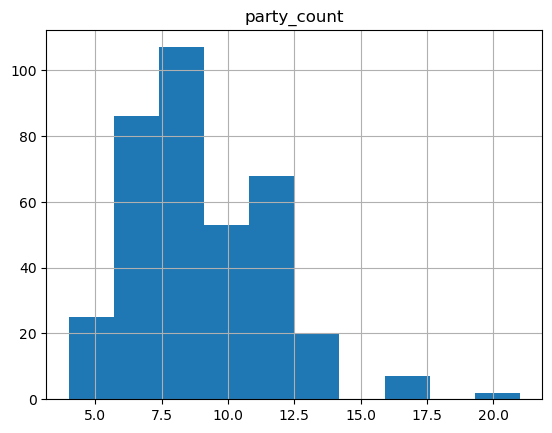

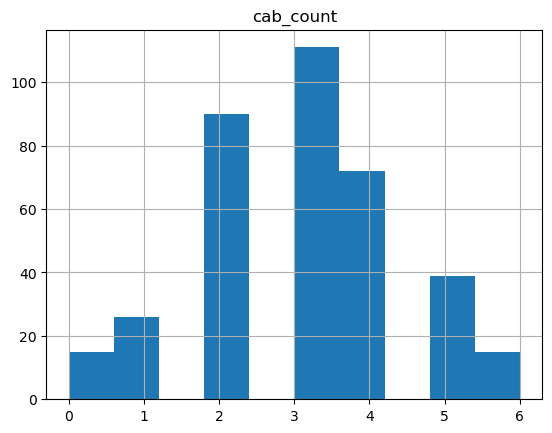

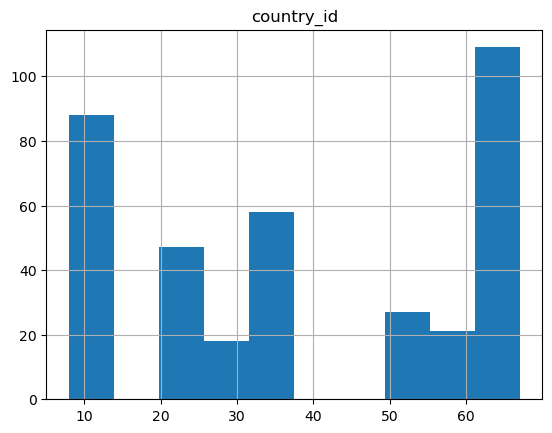

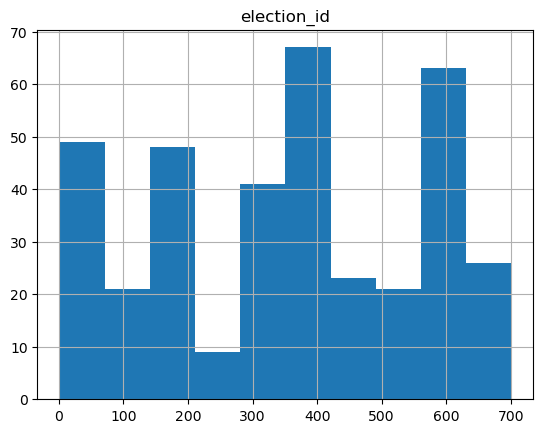

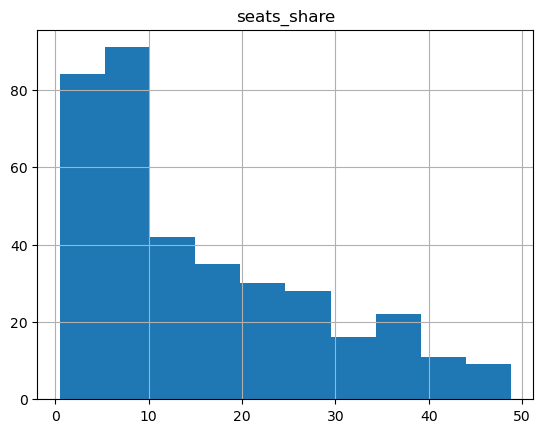

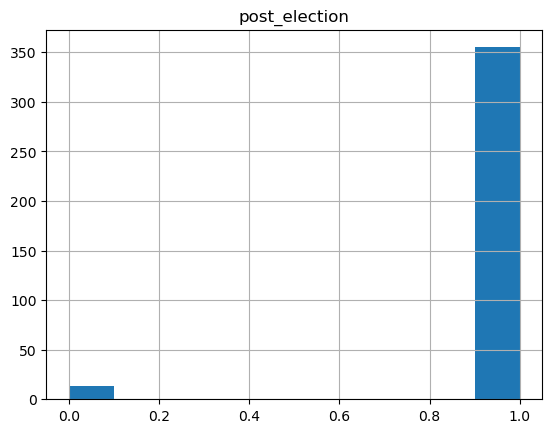

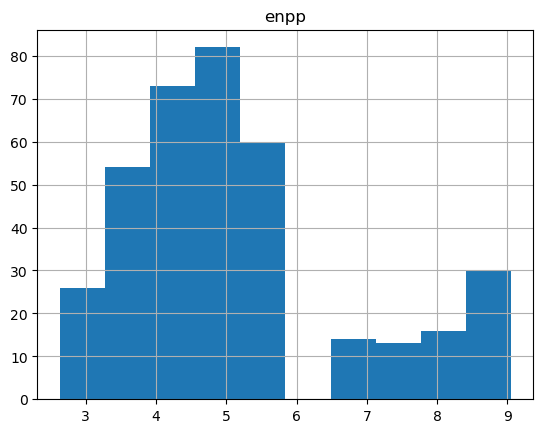

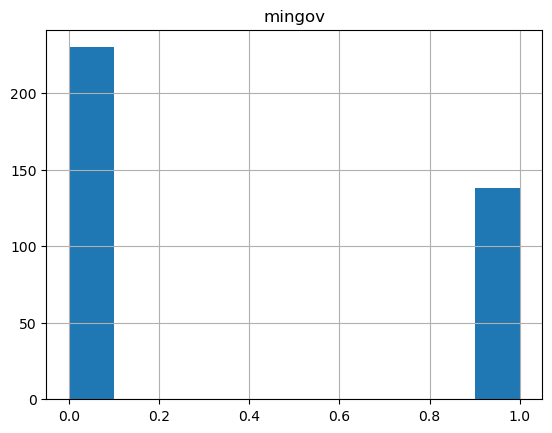

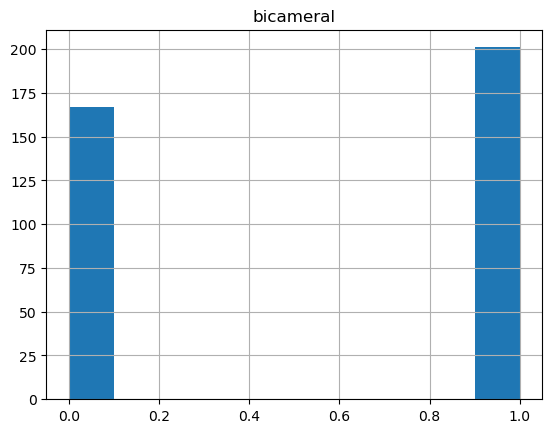

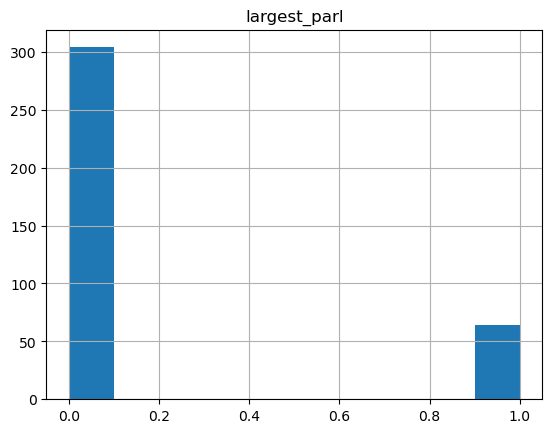

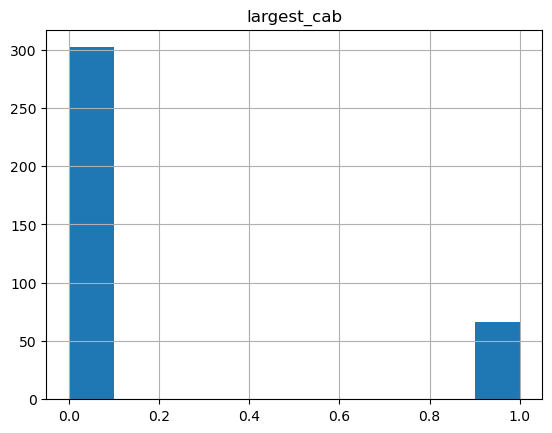

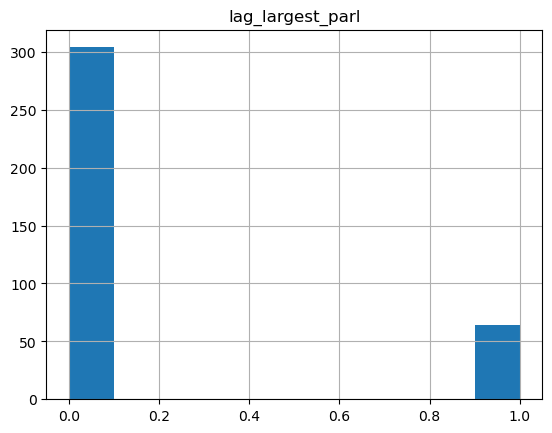

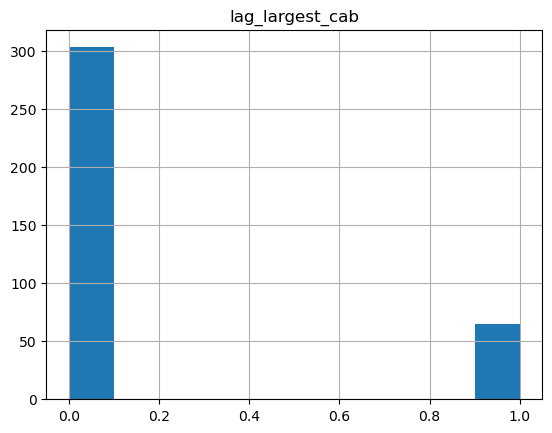

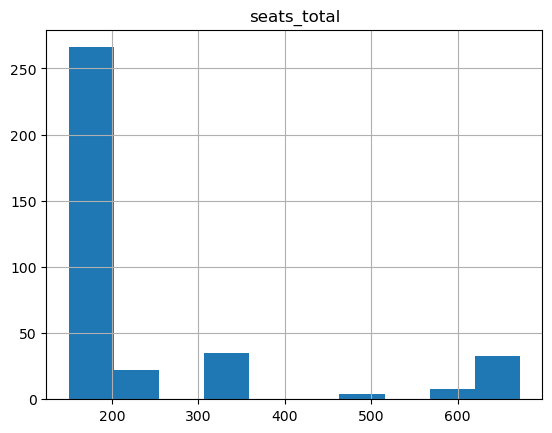

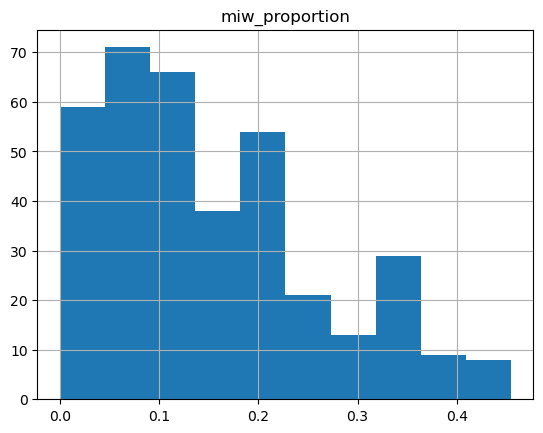

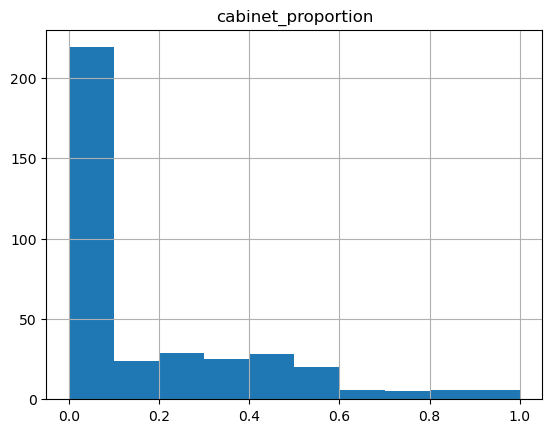

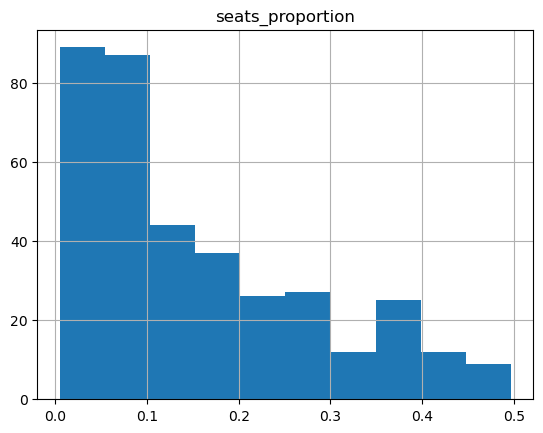

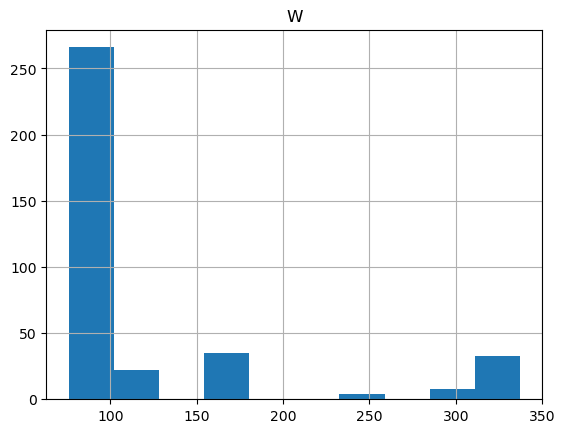

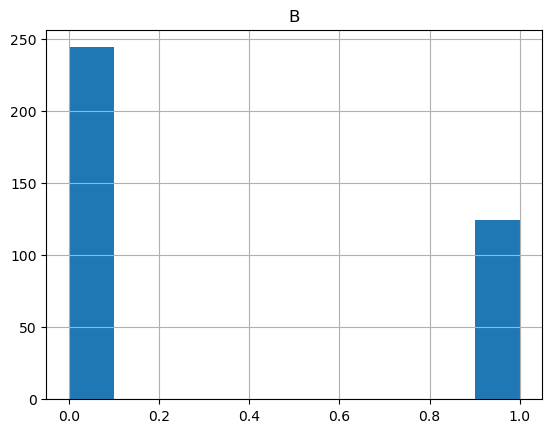

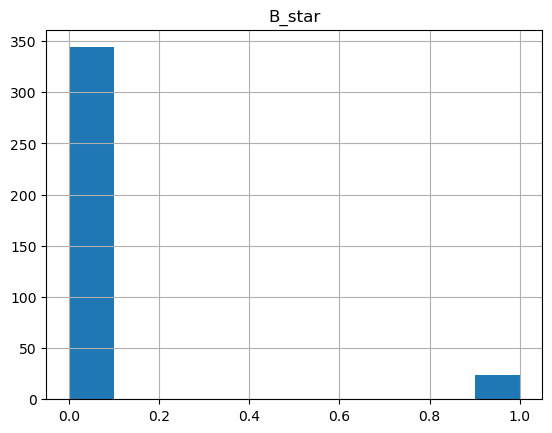

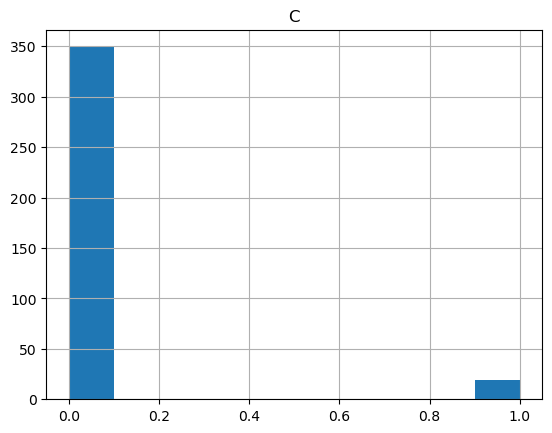

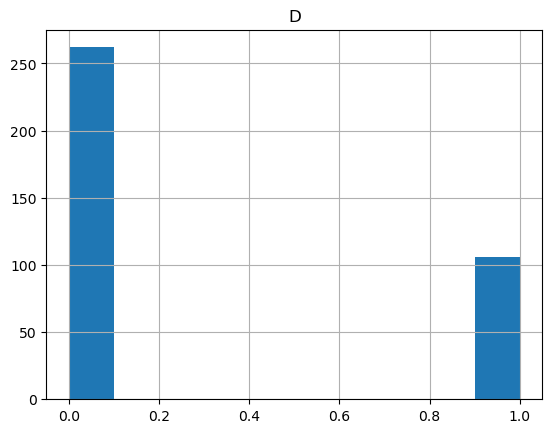

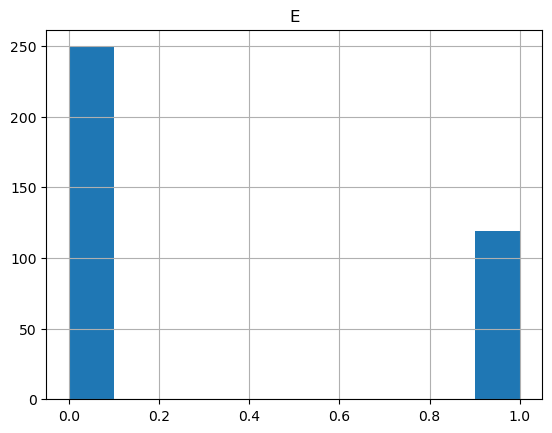

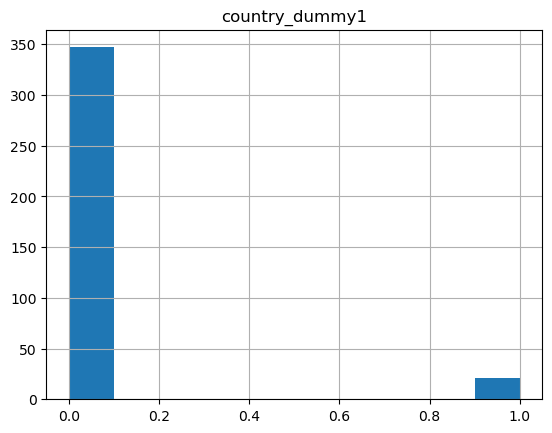

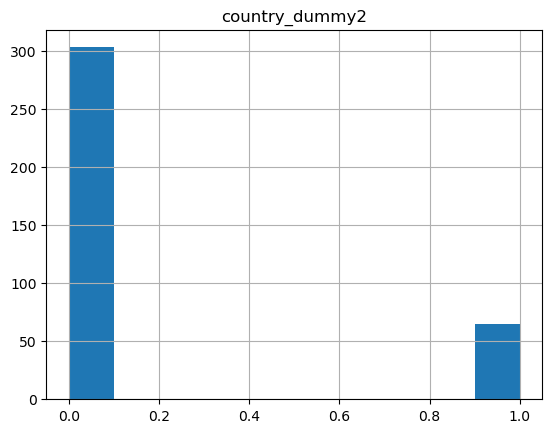

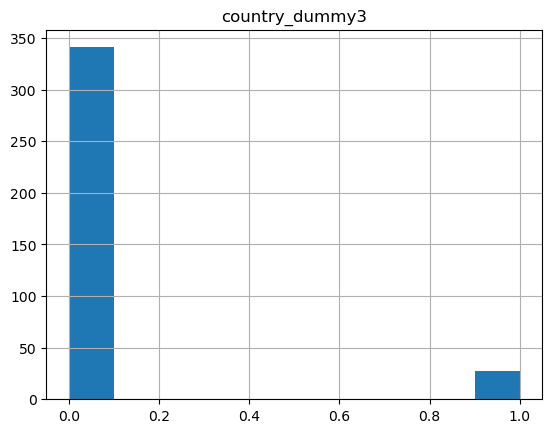

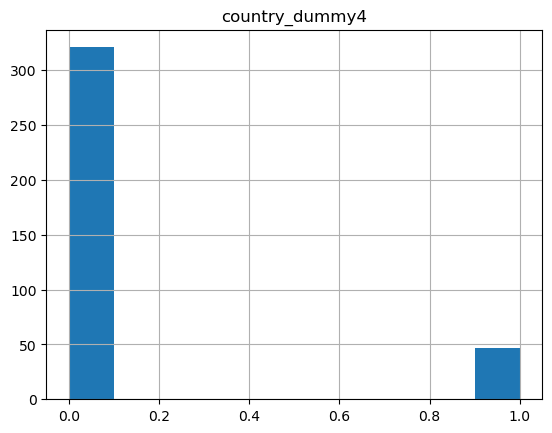

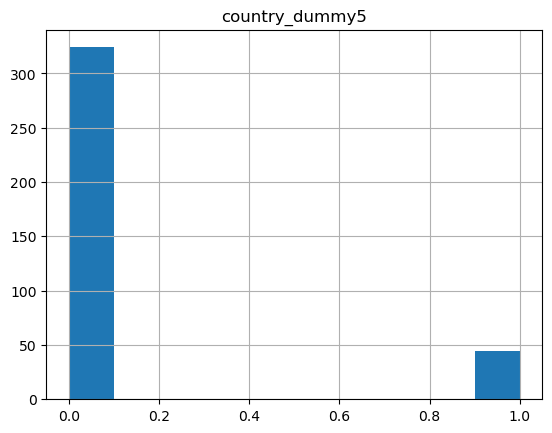

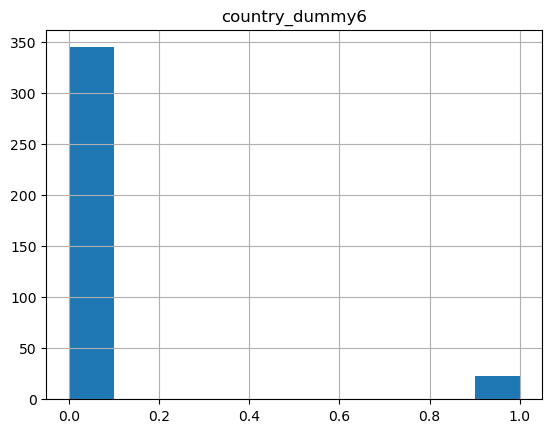

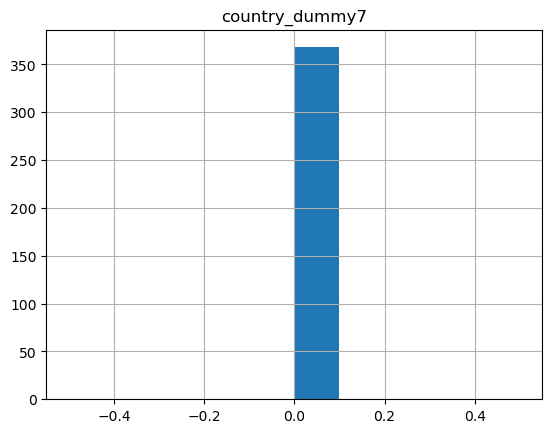

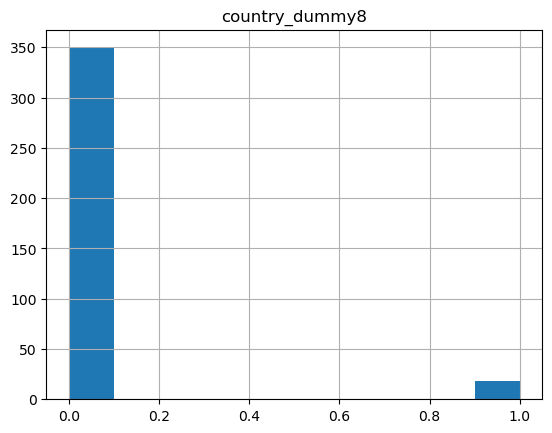

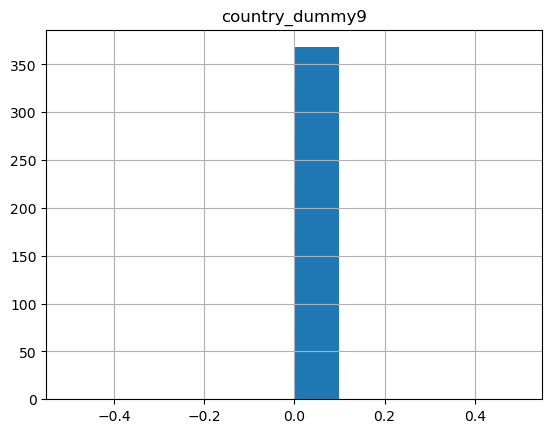

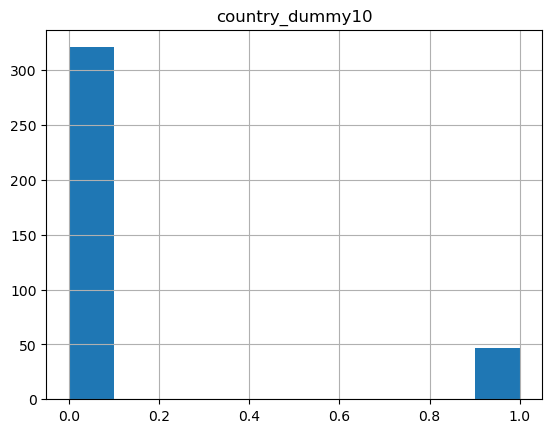

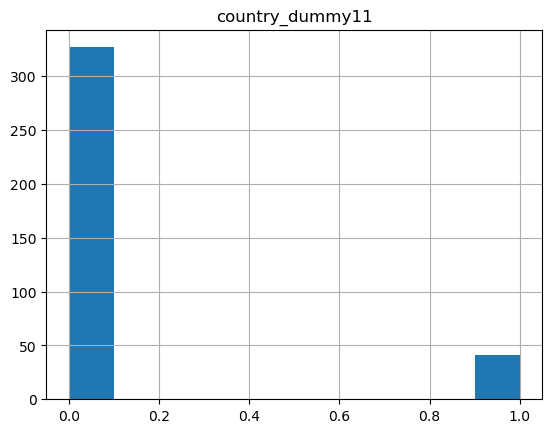

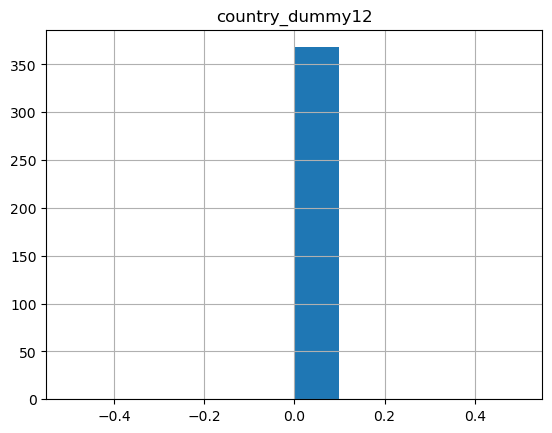

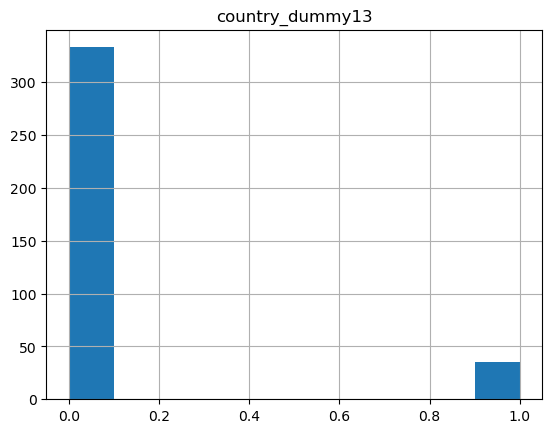

In [8]:
# step 7

# create histograms

# check if target variable is normally distributed/gaussian (spoiler: it's right-skewed and zero-inflated)
updated_data.hist(column='cabinet_proportion')

# histograms of the remaining IVs in updated_data 
updated_data.hist(column='seats')
updated_data.hist(column='sq_pm')
updated_data.hist(column='election_year')
updated_data.hist(column='base')
updated_data.hist(column='miw_new')
updated_data.hist(column='banzhaf')
updated_data.hist(column='shapley')
updated_data.hist(column='splus')
updated_data.hist(column='cabinet_id')
updated_data.hist(column='party_id')
updated_data.hist(column='caretaker')
updated_data.hist(column='cabinet_party')
updated_data.hist(column='prime_minister')
updated_data.hist(column='left_rightx')
updated_data.hist(column='left_righty')
updated_data.hist(column='cabinet_seats')
updated_data.hist(column='total_cabinet_size')
updated_data.hist(column='party_count')
updated_data.hist(column='cab_count')
updated_data.hist(column='country_id')
updated_data.hist(column='election_id')
updated_data.hist(column='seats_share')
updated_data.hist(column='post_election')
updated_data.hist(column='enpp')
updated_data.hist(column='mingov')
updated_data.hist(column='bicameral')
updated_data.hist(column='largest_parl')
updated_data.hist(column='largest_cab')
updated_data.hist(column='lag_largest_parl')
updated_data.hist(column='lag_largest_cab')
updated_data.hist(column='seats_total')
updated_data.hist(column='miw_proportion')
updated_data.hist(column='cabinet_proportion')
updated_data.hist(column='seats_proportion')
updated_data.hist(column='W')
updated_data.hist(column='B')
updated_data.hist(column='B_star')
updated_data.hist(column='C')
updated_data.hist(column='D')
updated_data.hist(column='E')
updated_data.hist(column='country_dummy1')
updated_data.hist(column='country_dummy2')
updated_data.hist(column='country_dummy3')
updated_data.hist(column='country_dummy4')
updated_data.hist(column='country_dummy5')
updated_data.hist(column='country_dummy6')
updated_data.hist(column='country_dummy7')
updated_data.hist(column='country_dummy8')
updated_data.hist(column='country_dummy9')
updated_data.hist(column='country_dummy10')
updated_data.hist(column='country_dummy11')
updated_data.hist(column='country_dummy12')
updated_data.hist(column='country_dummy13')

In [9]:
# step 8

# seaborn pairplot?
# don't run this cell because it takes hours to run

#sb.pairplot(updated_data)

/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

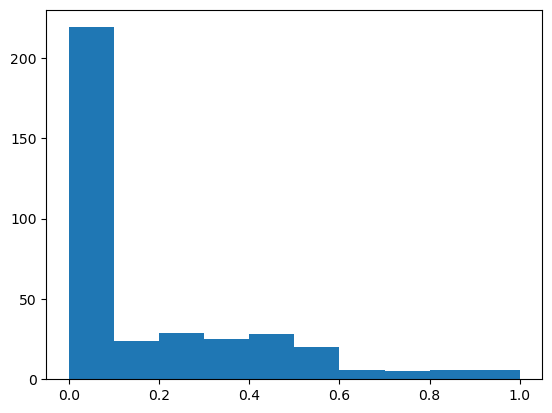

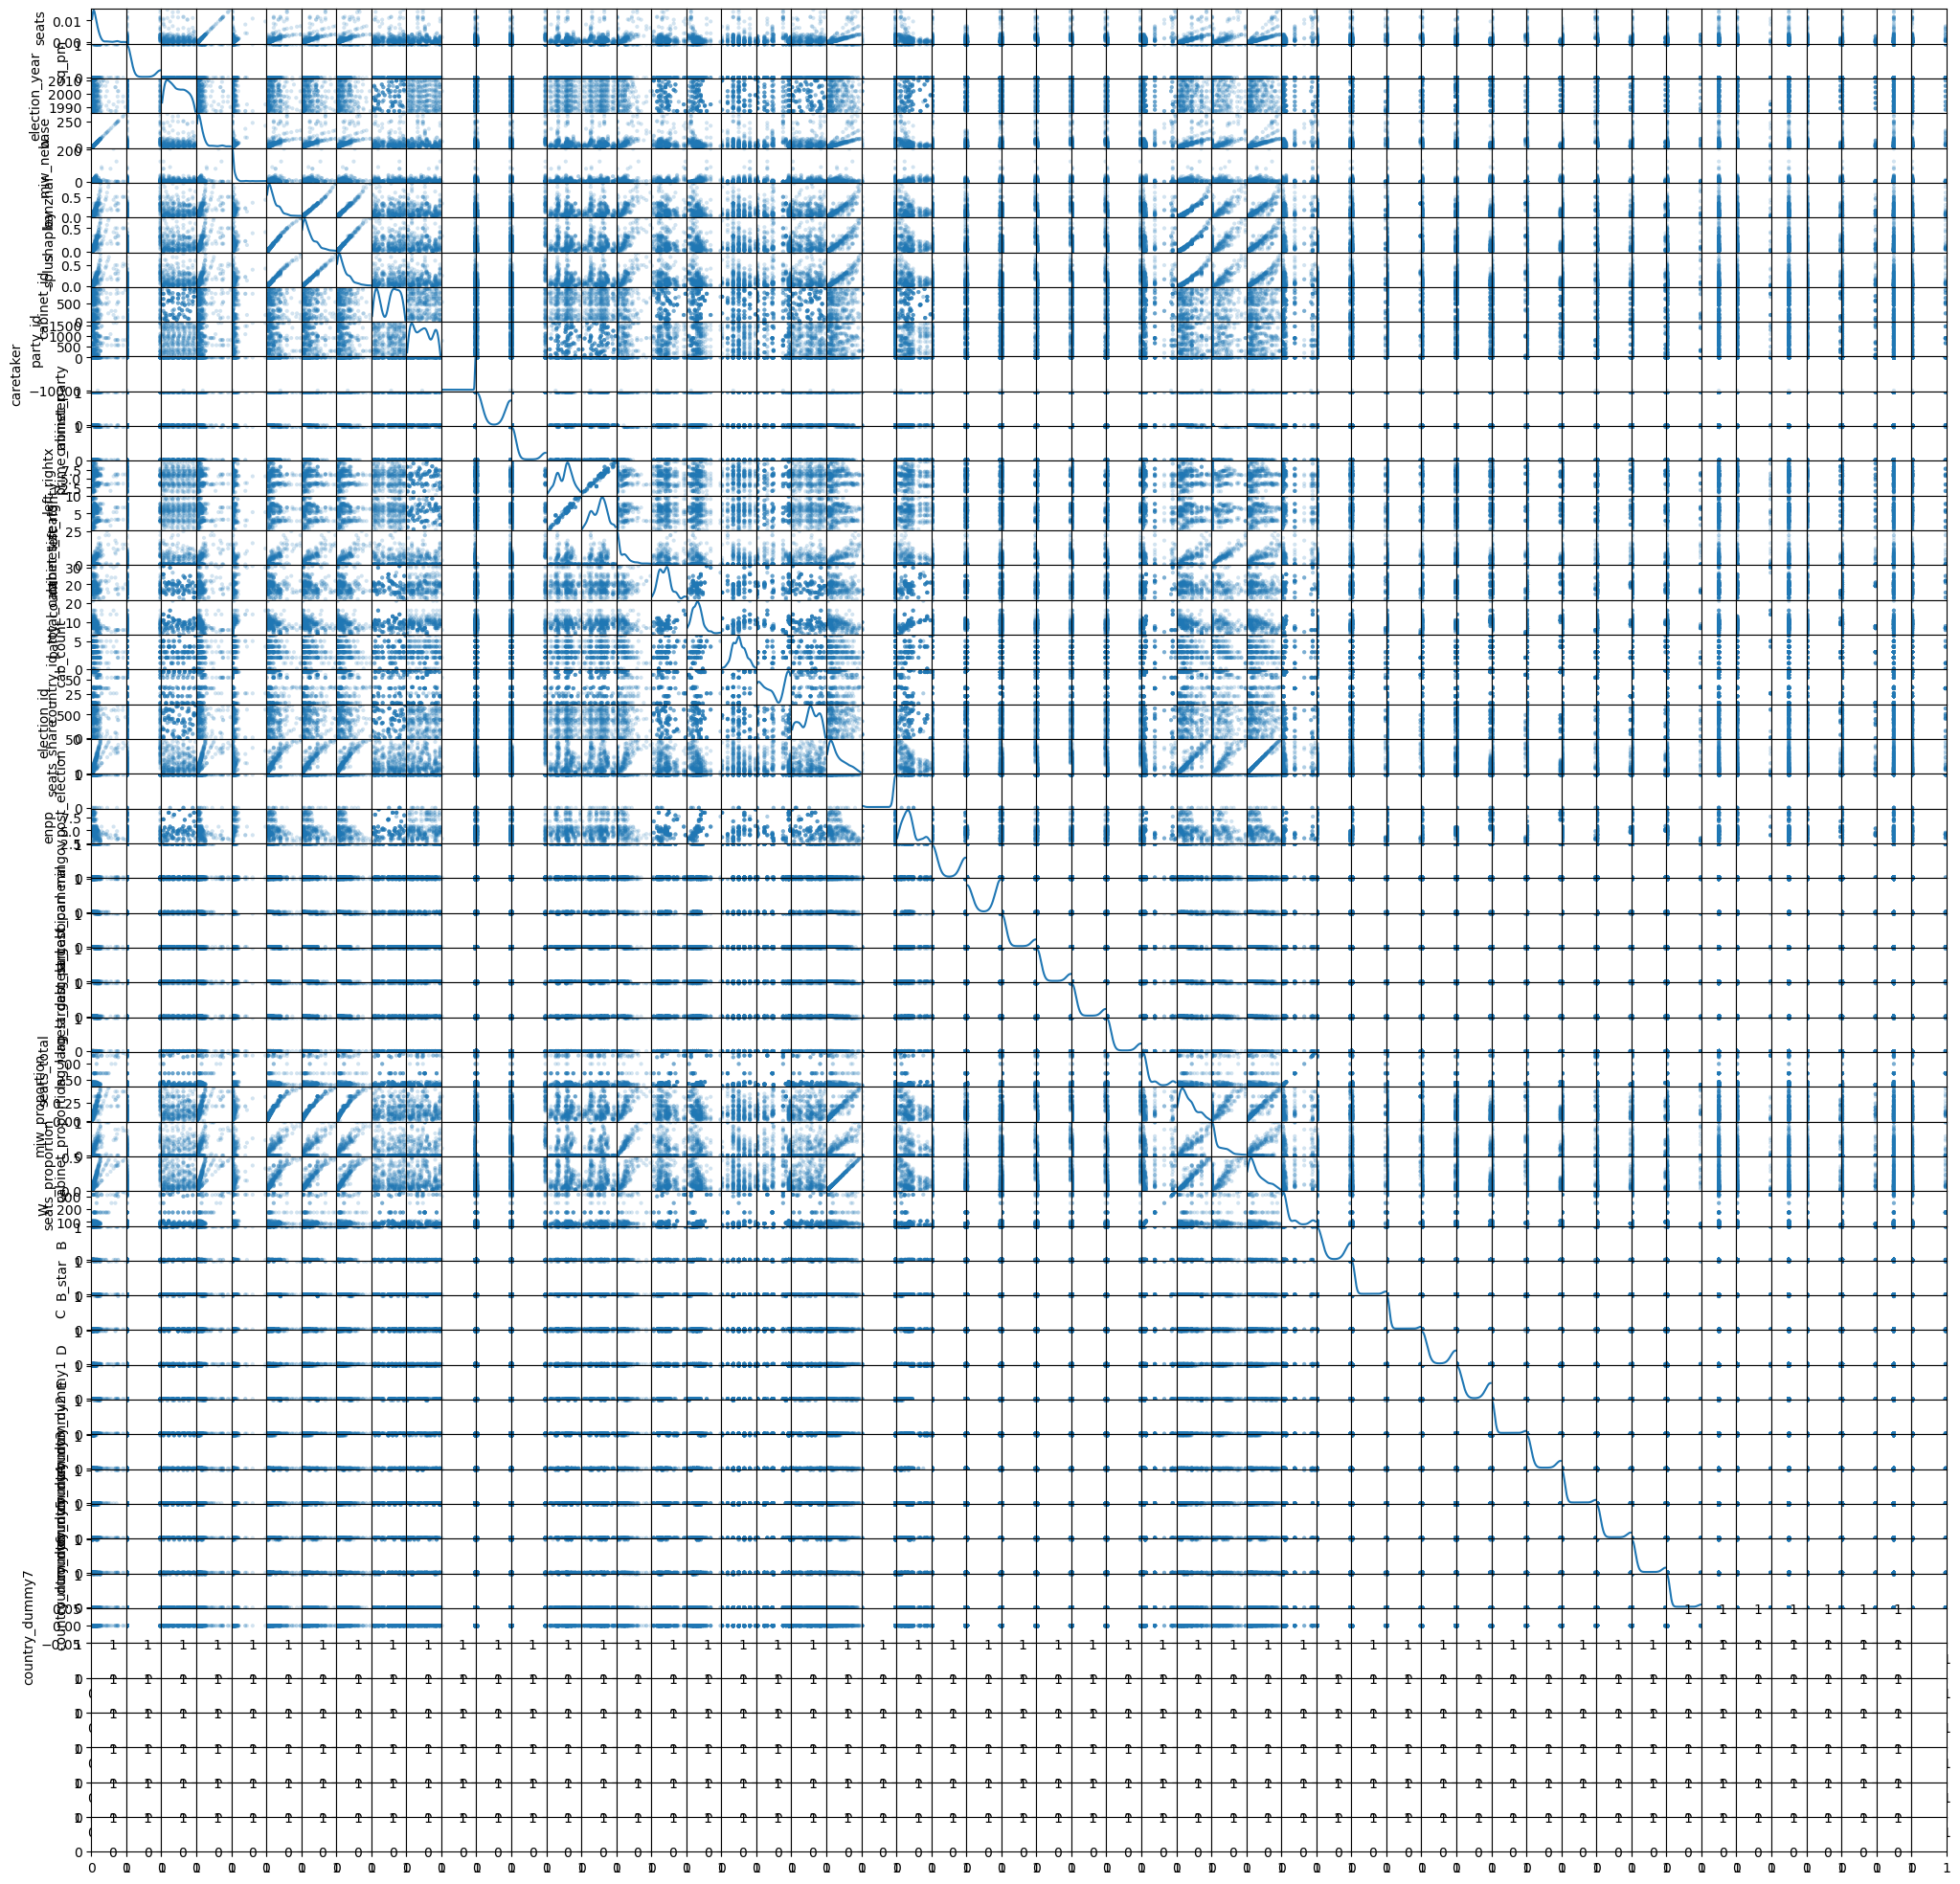

In [10]:
# alternative to seaborn pairplot and histograms (because seaborn pairplot takes too long to run)
# tends to get a linear algebra error (?) so that is to be expected. don't panic!
y = updated_data.loc[:, 'cabinet_proportion'].values

# another histogram of the zero-inflated DV 
plt.hist(y) 

# scatter matrix to see relationships between variables, basically a pairplot
from pandas.plotting import scatter_matrix

# change df to name of dataframe

# note to self - uncomment this line before u submit to @demarchi so he can see the LinAlgError
# problematic line
# comment it out if you want code to run or just click run on the next cell
scatter_matrix(updated_data, alpha=0.2, figsize=(25, 25), diagonal='kde')
plt.show()

# check that y is gaussian (it's not, it's right-skewed and zero-inflated)

In [11]:
# at this point, I've noticed that the y is a very much zero-inflated DV, so I won't be running OLS at all : P
# the LinAlgError was a reminder from the universe/anaconda to run PCA on this dataset!
# click run on this cell if you get LinAlgError/if the problematic line isn't commented out

In [12]:
# step 9

# run a baseline model (technically not an OLS)

# the naive model establishes my baseline expectations for an **ideal** model; 
# baseline expectation/ideal model RMSE = std of y = 0.1119, and MSE = sample variance of the naive model = 0.0124
# mean of y indicates the average predicted value of the model
print("standard deviation of y/ideal model RMSE:",str(round(np.std(y), 4)))
print("mean of y/ideal average predicted value of the model:" ,str(round(np.mean(y), 4)))
print("sample variance of y/ideal model MSE:",str(round(np.var(y), 4)))

standard deviation of y/ideal model RMSE: 0.243
mean of y/ideal average predicted value of the model: 0.1666
sample variance of y/ideal model MSE: 0.059


In [13]:
# step 10

# run VIF, put all vif values into a nice table

# note: if this cell output truncates the full table, look at next cell

# method used: sm.stats.outliers_influence.variance_inflation_factor(exog, exog_idx)
# exog : an array containing features on which linear regression is performed.
# exog_idx : index of the additional feature whose influence on the other features is to be measured.


# the independent variables set (alternatively just use vars)
x = updated_data[['seats', 'sq_pm', 'election_year', 'base', 'miw_new', 'banzhaf', 'shapley', 'splus', 'cabinet_id', 
                  'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'left_righty', 'cabinet_seats', 
                  'total_cabinet_size', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 
                  'enpp', 'mingov', 'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 
                  'miw_proportion', 'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 
                  'country_dummy3', 
                  'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 
                  'country_dummy10', 
                  'country_dummy11', 'country_dummy12', 'country_dummy13']]

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = x.columns 
  
x.dropna(inplace = True)
#print(len(X))

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(x.values, i) 
                          for i in range(len(x.columns))] 
  
print(vif_data)

/var/folders/c7/crsrylf52c54ymymjfs4ngww0000gn/T/ipykernel_31032/245078527.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.dropna(inplace = True)
/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               feature           VIF
0                seats           inf
1                sq_pm  3.471083e+00
2        election_year  2.297535e+00
3                 base           inf
4              miw_new  2.803306e+00
5              banzhaf  2.105689e+02
6              shapley  5.795499e+02
7                splus  2.098558e+02
8           cabinet_id  1.502296e+00
9             party_id  1.262118e+00
10           caretaker  1.407101e+00
11       cabinet_party  4.032470e+00
12      prime_minister  5.271343e+00
13         left_rightx  2.728914e+01
14         left_righty  2.803929e+01
15       cabinet_seats  8.252280e+00
16  total_cabinet_size  5.068516e+00
17         party_count  1.643675e+01
18           cab_count  3.202299e+00
19          country_id           inf
20         election_id  1.423487e+00
21         seats_share  2.921601e+02
22       post_election  1.602908e+00
23                enpp  2.283872e+01
24              mingov  3.787291e+00
25           bicameral           inf
2

/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [14]:
# I started panicking here because some of the VIF values were "NaN" or "inf" - but the inf ones make sense later, because 
# they're dummy variables for a specific country noticed that left_rightx and left_righty both have VIFs > 25 (incredibly 
# high, although haven't reached infinity yet). this might be a problem later.

In [15]:
# decided to run VIF again

In [16]:
# step 11

# run VIF again, but this time, have a threshold. this way, we can get a list of variables with high VIFs (and not just a 
# table that truncates)

# this chunk of code goes through the VIFs and returns/prints the variables that have a VIF above a threshold that you set

# feature variables are in a 2D numpy array named 'independent_data'
# uses a parallel list of variable names in 'independent_variable_names'

def select_features_with_low_vif(data, variable_names, threshold):
    # parameters: data itself, names of IVs, user-determiend threshold for what constitutes as "too high" of a VIF
    
    def calculate_vif(data):
        # parameter: data itself
        vif_data = np.zeros(data.shape[1])
        for i in range(data.shape[1]):
            vif_data[i] = variance_inflation_factor(data, i)
        return vif_data

    vif_scores = calculate_vif(data)
    high_vif_features = np.where(vif_scores > threshold)[0]
    
    high_vif_variable_names = [variable_names[i] for i in high_vif_features]
    print("Variables with VIF >", str(threshold), ":", high_vif_variable_names)
    print("number of variables with a VIF above the threshold:", str(len(high_vif_variable_names)))
    low_vif_data = np.delete(data, high_vif_features, axis=1)
    return low_vif_data

# set threshold for VIF
threshold_value = 10

independent_data = updated_data[['left_righty', 'seats', 'sq_pm', 'election_year', 'base', 'miw_new', 'banzhaf', 'shapley', 'splus', 
                                 'cabinet_id', 'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 
                                 'total_cabinet_size', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 
                                 'enpp', 'mingov', 'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 
                                 'seats_total', 'miw_proportion', 'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 
                                 'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 
                                 'country_dummy8', 'country_dummy9', 'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13']].to_numpy()
independent_variable_names = ['left_righty', 'seats', 'sq_pm', 'election_year', 'base', 'miw_new', 'banzhaf', 'shapley', 'splus', 'cabinet_id', 
                              'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 'total_cabinet_size', 
                              'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 
                              'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 
                              'miw_proportion', 'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 
                              'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 
                              'country_dummy9', 'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13']


# select the features in dataset with VIF above the threshold and print names of variables with VIF > 10
selected_features = select_features_with_low_vif(independent_data, independent_variable_names, threshold=threshold_value)

# note to self: how to use VIF to identify multicollinearity - vif estimates how much variance of a 
# variable can be explained by other variables. VIF > 5 or 10 is a sign of multicollinearity


/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Variables with VIF > 10 : ['left_righty', 'seats', 'base', 'banzhaf', 'shapley', 'splus', 'left_rightx', 'party_count', 'country_id', 'seats_share', 'enpp', 'bicameral', 'seats_total', 'miw_proportion', 'seats_proportion', 'W', 'B', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy8', 'country_dummy10', 'country_dummy11', 'country_dummy13']
number of variables with a VIF above the threshold: 30


In [17]:
# noticed that my second VIF attempt includes the infinity-valued VIF IVs as greater than threshold (which makes sense 
# because infinity > numeric threshold, but is still worrying)

In [18]:
# run a correlation matrix (even though it can't identify multicollinearity, just collinearity)

In [19]:
# step 12

# run a correlation matrix

# correlation matrix that tells us correlations between variables above a certain threshold, see output statements
# note to self: correlation matrix can show that the IVs have a massive amount of collinearity
# keep in mind this does not identify multicollinearity

# cm = df1.corr() # creates correlation matrix
new_dataframe = pd.DataFrame(updated_data, columns= ['left_righty', 'seats', 'sq_pm', 'election_year', 'base', 'miw_new', 
                                                     'banzhaf', 'shapley', 'splus', 'cabinet_id', 'party_id', 'caretaker', 
                                                     'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 
                                                     'total_cabinet_size', 'party_count', 'cab_count', 'country_id', 
                                                     'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 
                                                     'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 
                                                     'lag_largest_cab', 'seats_total', 'miw_proportion', 'seats_proportion', 
                                                     'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 
                                                     'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 
                                                     'country_dummy7', 'country_dummy8', 'country_dummy9', 'country_dummy10', 
                                                     'country_dummy11', 'country_dummy12', 'country_dummy13'])

# commented out 2 lines for printing out the data frame
#print("dataframe is : ")
#print(updated_data)

new_matrix = new_dataframe.corr()
print("correlation matrix! is: ")
print(new_matrix)

np.fill_diagonal(new_matrix.values, 0) # set diagonal to 0 
threshold = 0.6

# create couple where (feature1, feature2, value)
new_corr = [[new_matrix.index[x], new_matrix.columns[y], new_matrix.iloc[x,y]] for x, y in zip(*np.where(abs(np.tril(new_matrix)) > 
                                                                                                         threshold))] 
for couple in new_corr:
    feature1, feature2, value = couple

    # commented out because the output is super long, fix later before submit
    # can show us collinearity
    #print(f'{feature1} and {feature2} are correlated above a threshold of ' + str(threshold))
print(new_corr)



correlation matrix! is: 
                    left_righty     seats     sq_pm  election_year      base  \
left_righty            1.000000 -0.105539 -0.051598       0.002113 -0.105539   
seats                 -0.105539  1.000000  0.416000      -0.045224  1.000000   
sq_pm                 -0.051598  0.416000  1.000000       0.011042  0.416000   
election_year          0.002113 -0.045224  0.011042       1.000000 -0.045224   
base                  -0.105539  1.000000  0.416000      -0.045224  1.000000   
miw_new               -0.049090  0.200657  0.161276      -0.111819  0.200657   
banzhaf               -0.110753  0.608869  0.554251      -0.003020  0.608869   
shapley               -0.110776  0.629181  0.565742      -0.001120  0.629181   
splus                 -0.112559  0.630337  0.574804       0.000560  0.630337   
cabinet_id            -0.014430  0.041030  0.006350       0.296879  0.041030   
party_id               0.080363 -0.020027 -0.090886      -0.031929 -0.020027   
caretaker      

In [20]:
# step 13

# explanation on dropping and why I went back to the beginning and did more dropping

# noticed earlier that left_rightx and left_righty both have VIFs > 25. also noticed that left_rightx and left_righty were 
# correlated at 0.9660721319894967, except that left_righty was missing for 289 of the original 657 observations, while 
# left_rightx was only missing for 52 of the original observations.
# decided to drop left_righty, because it was too highly collinear with left_rightx for observations that had both 
# measurements, and light-righty had too much missingness in comparision went back and dropped it

# noticed that base and seats were correlated at 1.0 (they were identicial columns), and dropped base.

In [21]:
data2 = pd.read_csv("class_final_proportion.csv")
print("length of raw csv file:", len(data2))

# drop the data observations that are missing the target variable ('cabinet_proportion')
# alternatively run .info() to get idea of missingness if I'm picking a DV

updated_data = data2.dropna(subset=['cabinet_proportion'])
print(updated_data.head()) # prints the first few rows
print("# of obs with target variable:", len(updated_data))

# commented out so output isn't as long for scrolling
#updated_data.info()

columns_to_drop = ['coalition_total',    # colation_total is missing for 424 of the total 657 observations
                   'party_name',         # object/string type
                   'party',              # object/string type
                   'country',            # object/string type
                   'cabinet_name',       # object/string type
                   'party_name_english', # object/string type
                   'election_date',      # object/string type
                   'start_date',         # object/string type  
                   'left_righty',        # dropped because of missingness/collinearity with left_rightx    
                   'base']               # dropped because it was identical with seats/correlated at 1.0 with seats

updated_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# commented out so output isn't as long for scrolling
# print(updated_data)
print("# obs with string or object data-type IVs dropped/signif missingness columns dropped/:", len(updated_data))

# .dropna for rows with remaining missingness
updated_data=updated_data.dropna()
updated_data.info()
# commented out so output isn't as long for scrolling
#print(updated_data)


length of raw csv file: 657
   party  seats sq_cabinet  sq_pm  election_year  base  miw_new   banzhaf  \
0     MP     16          0    0.0           1998    16        1  0.054545   
1     SJ     25          1    1.0           2007    25        2  0.500000   
2  GRENG      5          0    0.0           1994     5        1  0.076923   
3  GRAEN      6          0    0.0           1999     6        1  0.166667   
4    CSV     21          1    1.0           1994    21        3  0.384615   

    shapley     splus  ... country_dummy5  country_dummy6  country_dummy7  \
0  0.052381  0.037114  ...              0               0               0   
1  0.500000  0.458311  ...              0               0               1   
2  0.066667  0.051242  ...              0               0               0   
3  0.166667  0.121258  ...              0               0               1   
4  0.400000  0.379442  ...              0               0               0   

  country_dummy8  country_dummy9  country_dumm

In [49]:
# step 14

# initialize y and IVs (for future modeling/i will update this once i run PCA for serious)

# independent vars initialized in a list
ind_vars = ['seats', 'sq_pm', 'election_year', 'miw_new', 'banzhaf', 'shapley', 'splus', 'cabinet_id', 'party_id', 
            'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 'total_cabinet_size', 
            'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 
            'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 'miw_proportion', 
            'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 
            'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 
            'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13']

# initialization of y
y = updated_data.loc[:, 'cabinet_proportion'].values


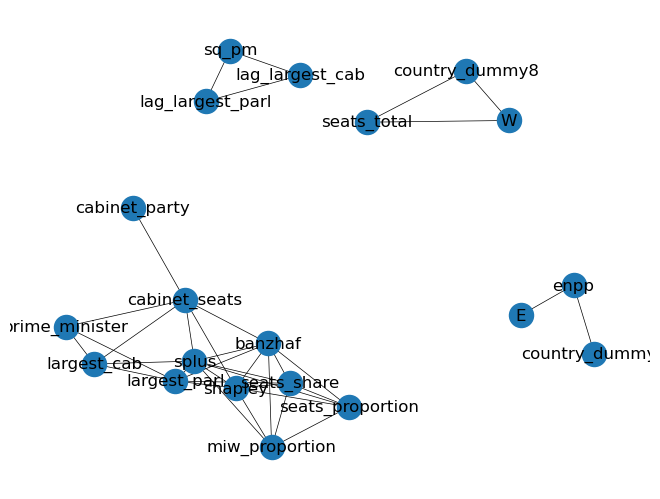

In [50]:
# step 15

# run a network diagram on the correlation matrix

import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()

# I got the idea for using a network to model the correlations matrix from Dr. Banks' class, most of the code 
# was from https://stackoverflow.com/questions/56717750/plotting-similarity-matrix-using-networkx
# corr_data is the list of correlation pairs generated from the correlation matrix (correlations above the threshold of 
# 0.7) I ran earlier


# correlation pairs are from the correlation matrix I ran earlier; all of these pairs had a correlation > 0.7 threshold
corr_data =([['shapley', 'banzhaf', 0.9957385529948837], ['splus', 'banzhaf', 0.991191061990342], ['splus', 'shapley', 0.9941259793578612], 
             ['cabinet_seats', 'banzhaf', 0.7209247145885321], ['cabinet_seats', 'shapley', 0.7234297922918674], ['cabinet_seats', 'splus', 
                                                                                                                  0.7381954978083721], 
            ['cabinet_seats', 'cabinet_party', 0.7409822646030996], ['cabinet_seats', 'prime_minister', 0.7519633916438362], 
            ['seats_share', 'banzhaf', 0.8842974609304702], ['seats_share', 'shapley', 0.901510539185165], 
            ['seats_share', 'splus', 0.9124463360373414], ['largest_parl', 'banzhaf', 0.7287864704064011], 
            ['largest_parl', 'shapley', 0.7366536530560375], ['largest_parl', 'splus', 0.7511762397724465], 
            ['largest_parl', 'prime_minister', 0.770567327664416], ['largest_parl', 'seats_share', 0.7001968020040181], 
            ['largest_cab', 'splus', 0.7058824092051798], ['largest_cab', 'prime_minister', 0.8972124511126173], 
            ['largest_cab', 'cabinet_seats', 0.7574259679399117], ['largest_cab', 'largest_parl', 0.8235759888115609], 
            ['lag_largest_parl', 'sq_pm', 0.7399593734854819], ['lag_largest_cab', 'sq_pm', 0.7961897147119703], 
            ['lag_largest_cab', 'lag_largest_parl', 0.8041935182590828], ['miw_proportion', 'banzhaf', 0.957135768971561], 
            ['miw_proportion', 'shapley', 0.9716596665910083], ['miw_proportion', 'splus', 0.9601144683497748], 
            ['miw_proportion', 'seats_share', 0.9081079917591821], ['seats_proportion', 'banzhaf', 0.8854426674740111], 
            ['seats_proportion', 'shapley', 0.9027762163540779], ['seats_proportion', 'splus', 0.9131492398252548], 
            ['seats_proportion', 'seats_share', 0.9975414031018188], ['seats_proportion', 'miw_proportion', 0.9094618626006905], 
            ['W', 'seats_total', 0.9999962083682243], ['E', 'enpp', 0.7901732430392006], ['country_dummy2', 'enpp', 0.768642580605493], 
            ['country_dummy8', 'seats_total', 0.7432885299986306], ['country_dummy8', 'W', 0.7432479964468661]])

corr_data = [[x[0],x[1],0.01**(x[2])] for x in corr_data]

existing_edges = {}
def build_graph(w, lev):
  if (lev > 5)  :
      return
  for z in corr_data:
     ind=-1 
     if z[0] == w:
         ind=0
         ind1=1
     if z[1] == w:
         ind ==1
         ind1 =0
     if ind == 0 or ind == 1:
         if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :
             G.add_node(str(corr_data[ind]))
             existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
             G.add_edge(w,str(corr_data[ind1]))
             build_graph(corr_data[ind1], lev+1)

existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
            return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
             G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()

pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=0.5, with_labels=True)

plt.savefig("path1.png")

In [51]:
# what this network means: the closer two nodes (each node is an IV) are to each other, the higher their correlation.
# if an edge doesn't exist between two nodes, there is no correlation between them above the listed threshold (aka the 
# inputted list of correlation pairs)
# this network helped guide my choices for feature selection for PCA

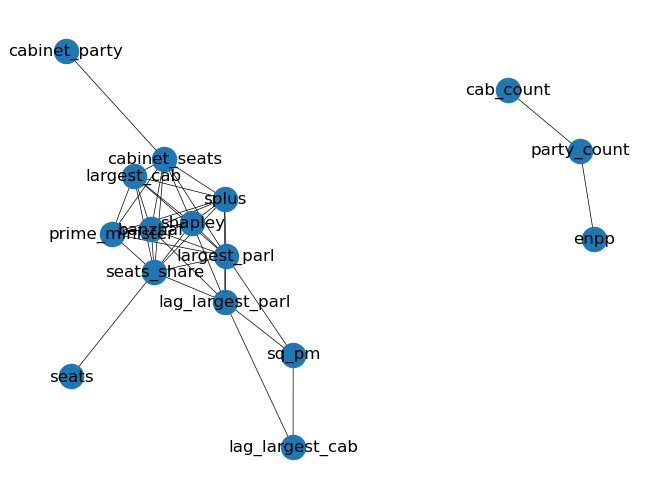

In [52]:
# I decided to run the network again, except with a lower correlation threshold for the pairs

# correlation pairs are from the correlation matrix I ran earlier; all of these pairs had a correlation > 0.6 threshold 
# (I went back and changed the threshold in order to get this new list of correlation pairs)

G=nx.Graph()

corr_data =([['shapley', 'banzhaf', 0.9957385529948837], ['splus', 'banzhaf', 0.991191061990342], ['splus', 'shapley', 0.9941259793578612], 
             ['prime_minister', 'banzhaf', 0.6661458823097164], ['prime_minister', 'shapley', 0.678135899265676], 
             ['prime_minister', 'splus', 0.6912498003186179], ['cabinet_seats', 'banzhaf', 0.7209247145885321], 
             ['cabinet_seats', 'shapley', 0.7234297922918674], ['cabinet_seats', 'splus', 0.7381954978083721], 
             ['cabinet_seats', 'cabinet_party', 0.7409822646030996], ['cabinet_seats', 'prime_minister', 0.7519633916438362], 
             ['cab_count', 'party_count', 0.6102295632498991], ['seats_share', 'seats', 0.6683577616764718], 
             ['seats_share', 'banzhaf', 0.8842974609304702], ['seats_share', 'shapley', 0.901510539185165], 
             ['seats_share', 'splus', 0.9124463360373414], ['seats_share', 'prime_minister', 0.6402151926505747], 
             ['seats_share', 'cabinet_seats', 0.6686008740622305], ['enpp', 'party_count', 0.6349687054989988], 
             ['largest_parl', 'sq_pm', 0.617466941029286], ['largest_parl', 'banzhaf', 0.7287864704064011], 
             ['largest_parl', 'shapley', 0.7366536530560375], ['largest_parl', 'splus', 0.7511762397724465], 
             ['largest_parl', 'prime_minister', 0.770567327664416], ['largest_parl', 'cabinet_seats', 0.6309755798299564], 
             ['largest_parl', 'seats_share', 0.7001968020040181], ['largest_cab', 'banzhaf', 0.679962137259357], 
             ['largest_cab', 'shapley', 0.6927477808898924], ['largest_cab', 'splus', 0.7058824092051798], 
             ['largest_cab', 'prime_minister', 0.8972124511126173], ['largest_cab', 'cabinet_seats', 0.7574259679399117], 
             ['largest_cab', 'seats_share', 0.6551826585411772], ['largest_cab', 'largest_parl', 0.8235759888115609], 
             ['lag_largest_parl', 'sq_pm', 0.7399593734854819], ['lag_largest_parl', 'banzhaf', 0.6122373038701998], 
             ['lag_largest_parl', 'shapley', 0.6179458276195477], ['lag_largest_parl', 'splus', 0.6268872514384184], 
             ['lag_largest_parl', 'seats_share', 0.6284694056805585], ['lag_largest_parl', 'largest_parl', 0.6677554672893513], 
             ['lag_largest_cab', 'sq_pm', 0.7961897147119703], ['lag_largest_cab', 'lag_largest_parl', 0.8041935182590828], 
             ['miw_proportion', 'seats', 0.6029756489284399], ['miw_proportion', 'banzhaf', 0.957135768971561], 
             ['miw_proportion', 'shapley', 0.9716596665910083], ['miw_proportion', 'splus', 0.9601144683497748], 
             ['miw_proportion', 'prime_minister', 0.6330583191863638], ['miw_proportion', 'cabinet_seats', 0.6755663317628886], 
             ['miw_proportion', 'seats_share', 0.9081079917591821], ['miw_proportion', 'largest_parl', 0.6818501751779121], 
             ['miw_proportion', 'largest_cab', 0.6514988386009852], ['seats_proportion', 'seats', 0.6927061689074979], 
             ['seats_proportion', 'banzhaf', 0.8854426674740111], ['seats_proportion', 'shapley', 0.9027762163540779], 
             ['seats_proportion', 'splus', 0.9131492398252548], ['seats_proportion', 'prime_minister', 0.6439630331883701], 
             ['seats_proportion', 'cabinet_seats', 0.671948996262958], ['seats_proportion', 'seats_share', 0.9975414031018188], 
             ['seats_proportion', 'largest_parl', 0.6931575016695813], ['seats_proportion', 'largest_cab', 0.6551281545630068], 
             ['seats_proportion', 'lag_largest_parl', 0.6198835797994706], ['seats_proportion', 'miw_proportion', 0.9094618626006905], 
             ['W', 'seats_total', 0.9999962083682243], ['B', 'enpp', -0.6088941096581131], ['E', 'enpp', 0.7901732430392006], 
             ['country_dummy1', 'C', 0.681772752557391], ['country_dummy2', 'enpp', 0.768642580605493], 
             ['country_dummy2', 'E', 0.6088903634871179], ['country_dummy8', 'party_count', 0.6474888113100995], 
             ['country_dummy8', 'seats_total', 0.7432885299986306], ['country_dummy8', 'W', 0.7432479964468661]])

corr_data = [[x[0],x[1],0.01**(x[2])] for x in corr_data]

existing_edges = {}
def build_graph(w, lev):
  if (lev > 5)  :
      return
  for z in corr_data:
     ind=-1 
     if z[0] == w:
         ind=0
         ind1=1
     if z[1] == w:
         ind ==1
         ind1 =0
     if ind == 0 or ind == 1:
         if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :
             G.add_node(str(corr_data[ind]))
             existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
             G.add_edge(w,str(corr_data[ind1]))
             build_graph(corr_data[ind1], lev+1)

existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
            return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
             G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()

pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=0.5, with_labels=True)

plt.savefig("path1.png")

In [53]:
# step 16

# run PCA but with feature selection beforehand/use some theory

# variables used in this PCA: splus, shapley, banzhaf, miw_proportion

df = updated_data.copy()

# create a PCA method
def runPCA(x,v):
    pca = PCA()
    
    model = pca.fit(StandardScaler().fit_transform(x[v]))
    n_pcs = pca.n_components_
        
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
    #print(model.components_)
    initial_feature_names = v
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df2 = pd.DataFrame(dic.items())
    print()
    print ('number of principal components', n_pcs)
    print()
    
    # print out explained variance ratios in a horizontal list + scientific notation (hard to read)
    #print ('explained variance ratio for each principal component:', pca.explained_variance_ratio_)

    # print out explained variance ratios in a list + rounded (easy to look at)
    i = 1
    for evr in pca.explained_variance_ratio_:
        message = 'principal component ' + str(i) + ":"
        print(message, round(evr, 4))
        i += 1
    print()

    # you can print out the components themselves, but you can also print out in a table (see nested for-loops)
    #print('PCA components themselves:', pca.components_)
    #print()

    # nested for-loops that print out a neat table for looking at the components
    # the frist column is the first latent variable/first principal component, etc. 
    # read from up to down to get the coefficients for that principal component.
    for i in range(len(pca_vars)):
        print("x", i, ": ", end='')
        for j in range(n_pcs):
            print(round(pca.components_[j][i], 4), ", ", end='')
        print(pca_vars[i], end='')
        print("\n")
    return  df2 , model

pca_vars = ['splus', 'shapley', 'banzhaf', 'miw_proportion']

table, model = runPCA(df,pca_vars) #running pca on farming like variables
#table


number of principal components 4

principal component 1: 0.9838
principal component 2: 0.0134
principal component 3: 0.0022
principal component 4: 0.0005

x 0 : 0.5013 , 0.3174 , 0.7764 , 0.2124 , splus

x 1 : 0.5034 , 0.1467 , -0.156 , -0.8371 , shapley

x 2 : 0.5012 , 0.3795 , -0.6106 , 0.4817 , banzhaf

x 3 : 0.4941 , -0.8566 , -0.0095 , 0.1487 , miw_proportion



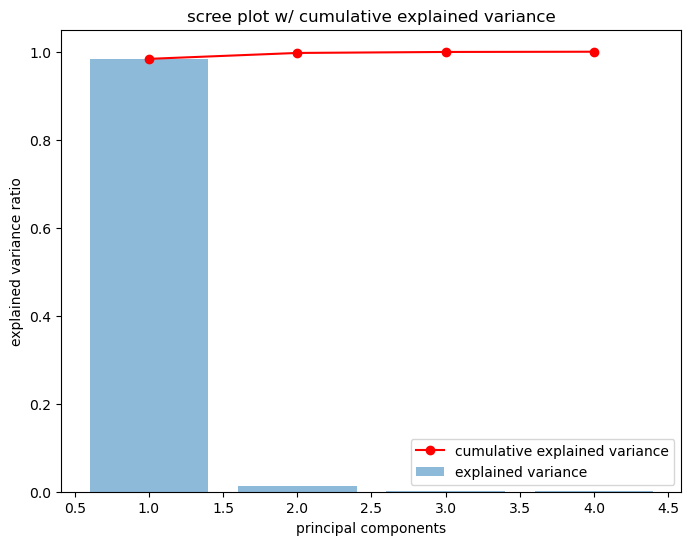

In [54]:
# get explained variance ratios and calculate cumulative explained variance

pca = PCA().fit(StandardScaler().fit_transform(df[pca_vars]))
explained_var = pca.explained_variance_ratio_
cumulative_explained_var = np.cumsum(explained_var)

# create scree plot with cumulative explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_var) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='explained variance')
plt.plot(range(1, len(explained_var) + 1), cumulative_explained_var, marker='o', linestyle='-', color='r', 
         label='cumulative explained variance')
plt.ylabel('explained variance ratio')
plt.xlabel('principal components')
plt.title('scree plot w/ cumulative explained variance')
plt.legend()
plt.show()

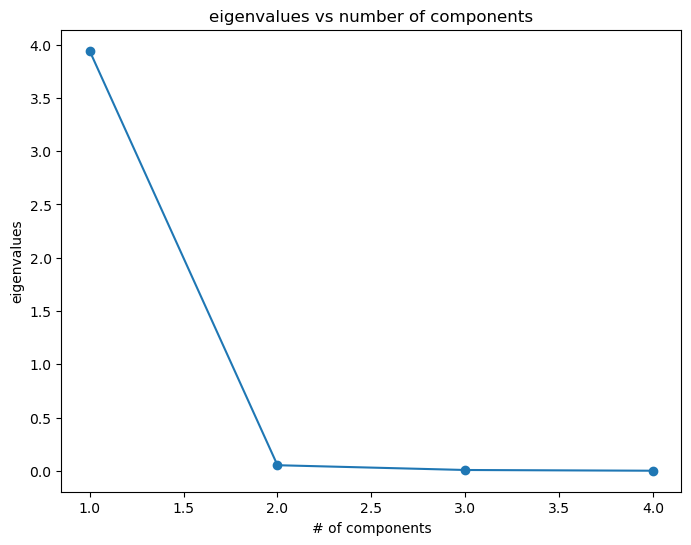

eiganvalue for principal component 1: 3.9417573326576023

eiganvalue for principal component 2: 0.05379240589193565

eiganvalue for principal component 3: 0.008984851960994005

eiganvalue for principal component 4: 0.0021543727001715977



In [55]:
# get eigenvalues
eigenvalues = pca.explained_variance_

# plot eigenvalues vs number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')

plt.xlabel('# of components')
plt.ylabel('eigenvalues')
plt.title('eigenvalues vs number of components')
plt.grid(False)
plt.show()

# note: the kaiser rule in PCA suggests that only retaining principal components with eigenvalues > 1 
# because that indicates that the principal component explains more variance in the target variable vs. 
# any other individual original IV. 
# this can simplify our selection of meaningful principal components - it aids in dimensionality reduction (aka pca) 
# so we only focus on the substantive components

components = pca.components_

# print principal components and their corresponding eigenvalues
for i, (component, eigenvalue) in enumerate(zip(components, eigenvalues)):
    #print(f"principal component {i + 1}:\n{component}")
    print(f"eiganvalue for principal component {i + 1}: {eigenvalue}\n")

In [56]:
# defining new IVs/latent variables after running principal component analysis

ind_vars = ['seats', 'sq_pm', 'election_year', 'miw_new', 'banzhaf', 'shapley', 'splus', 'cabinet_id', 'party_id', 'caretaker', 
            'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 'total_cabinet_size', 'party_count', 'cab_count', 
            'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 'bicameral', 'largest_parl', 
            'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 'miw_proportion', 'seats_proportion', 'W', 
            'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 'country_dummy4', 
            'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 'country_dummy10', 
            'country_dummy11', 'country_dummy12', 'country_dummy13']

# remove variables used to create pca_vars from vars
for i in pca_vars:
    if i in ind_vars:
        ind_vars.remove(i)

# shapley was giving me issues (no clue why it stayed in ind_vars even though the for loop above was supposed to take it out 
# because it's in pca_vars), so I removed it here (just in case))
if 'shapley' in ind_vars:
    ind_vars.remove('shapley')

# only appended one principal component, because we're only keeping one!
ind_vars.append('PC0')

# don't need this, we are not adding all four principal components:
#ind_vars.append('PC1')
#ind_vars.append('PC2')
#ind_vars.append('PC3')

# print variables in pca and variables in ind_vars just to make sure everythign worked
print("ind_vars", ind_vars)
print(len(ind_vars))
print("vars in pca", pca_vars)

pca2 = PCA(n_components=4) # using 1 component bc that explains the majority of variance

latent_vars = pca2.fit(StandardScaler().fit_transform(df[pca_vars]))
#print ("variance explained by each latent variable in PCA: ", pca2.explained_variance_ratio_)
updated_data['PC0'] = latent_vars.transform(StandardScaler().fit_transform(df[pca_vars]))[:,0]

# don't need this because I'm not adding all four principal components:
#df['PC1'] = latent_vars.transform(StandardScaler().fit_transform(df[pca_vars]))[:,1]
#df['PC2'] = latent_vars.transform(StandardScaler().fit_transform(df[pca_vars]))[:,2]
#df['PC3'] = latent_vars.transform(StandardScaler().fit_transform(df[pca_vars]))[:,3]

ind_vars ['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'cabinet_seats', 'total_cabinet_size', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13', 'PC0']
47
vars in pca ['splus', 'shapley', 'banzhaf', 'miw_proportion']


In [57]:
# step 17

# run an equation on k-fold on linear regression to estimate test error

# I know you're not supposed to run a linear regression on a zero-inflated target-variable (because you can't do OLS 
# for that type of DV distribution), but I was curious to see how bad it could get.
# Lo and behold, the test R-squared for k-fold was about -3.60. which underscores the idea that OLS is a shitshow for 
# zero-inflated data.

# initialize the data 
X, y = updated_data[ind_vars], updated_data["cabinet_proportion"]

# set number of folds for cross-validation
k_folds = 10  # adjust as needed

# initialize kfold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# initialize the lists to store info for the equation and evaluation metrics for each fold
train_mse_list = []
test_mse_list = []
train_r2_list = []
test_r2_list = []

# iterate through the folds
for train_index, test_index in kf.split(X):
    #X_train, X_test = X[train_index], X[test_index]  # split data into train and test folds
    #y_train, y_test = y[train_index], y[test_index]

    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # initialize the model you're running k-fold CV for (in this case, linear regression model)
    model = LinearRegression()

    # fit the model on the training fold
    model.fit(x_train, y_train)

    # predict on training and test folds
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # calculate MSE and R-squared for training and test folds
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # store evaluation metrics for each fold
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# calclate average MSE, and R² across all folds
avg_train_mse = np.mean(train_mse_list)
avg_test_mse = np.mean(test_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)


print(f"avg train MSE: {avg_train_mse:.2f}")
print(f"avg test MSE: {avg_test_mse:.2f}")
print(f"avg train R²: {avg_train_r2:.2f}")
print(f"avg test R²: {avg_test_r2:.2f}")

avg train MSE: 0.00
avg test MSE: 0.22
avg train R²: 0.97
avg test R²: -3.60


In [58]:
# step 18

ind_vars.remove("cabinet_seats")
ind_vars.remove("total_cabinet_size")

print(ind_vars)
print(len(ind_vars))

# conduct a train test split 

#train test split
x_train, x_test, y_train, y_test = train_test_split(updated_data[ind_vars], y, test_size=0.5, random_state=17)

# made copies of the splits, just in case
x_train2 = x_train.copy(deep=True)
x_test2 = x_test.copy(deep=True)
y_train2 = y_train.copy(deep=True)
y_test2 = y_test.copy(deep=True)

x_train3 = x_train.copy(deep=True)
x_test3 = x_test.copy(deep=True)
y_train3 = y_train.copy(deep=True)
y_test3 = y_test.copy(deep=True)

x_train4 = x_train.copy(deep=True)
x_test4 = x_test.copy(deep=True)
y_train4 = y_train.copy(deep=True)
y_test4 = y_test.copy(deep=True)

x_train5 = x_train.copy(deep=True)
x_test5 = x_test.copy(deep=True)
y_train5 = y_train.copy(deep=True)
y_test5 = y_test.copy(deep=True)

x_train6 = x_train.copy(deep=True)
x_test6 = x_test.copy(deep=True)
y_train6 = y_train.copy(deep=True)
y_test6 = y_test.copy(deep=True)

x_train7 = x_train.copy(deep=True)
x_test7 = x_test.copy(deep=True)
y_train7 = y_train.copy(deep=True)
y_test7 = y_test.copy(deep=True)

# make sure results/splits make sense before moving on
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

# print out the variables and pca variables just to make sure appending worked in previous cell/would work in the split
print(ind_vars)
print(pca_vars)

['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total', 'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13', 'PC0']
45
(299, 45) (299,)
(300, 45) (300,)
['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'post_election', 'enpp', 'mingov', 'bicameral', 'largest_parl', 'largest_cab', 'lag_largest_parl', 'lag_largest_ca

/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e-02, tolerance: 1.718e-03
  model = cd_fast.enet_coordinate_descent(
/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e-02, tolerance: 1.718e-03
  model = cd_fast.enet_coordinate_descent(
/Users/helloamyzhang/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

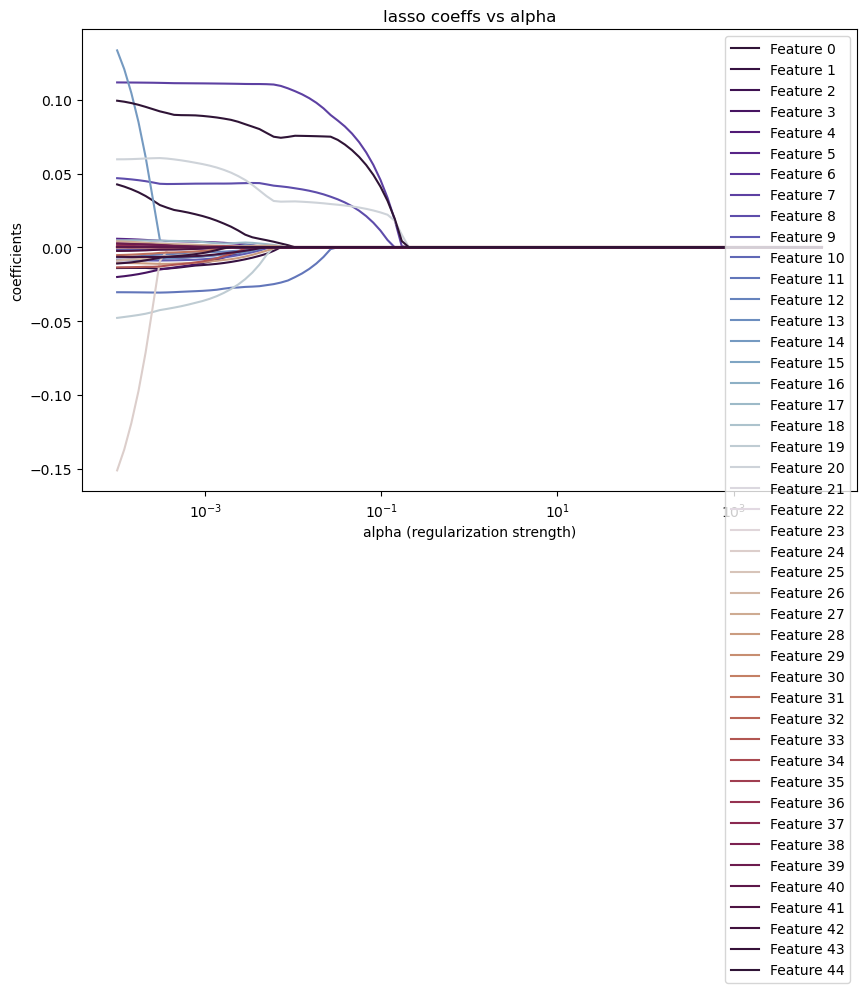

Index(['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id',
       'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx',
       'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share',
       'post_election', 'enpp', 'mingov', 'bicameral', 'largest_parl',
       'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'seats_total',
       'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1',
       'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5',
       'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9',
       'country_dummy10', 'country_dummy11', 'country_dummy12',
       'country_dummy13', 'PC0'],
      dtype='object')


In [59]:
# step 19

# lasso - used as regularization to cut down on the number of IVs I'll use in poly later.

from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
scaler = StandardScaler()

#print(x_train)
x_train_scaled = scaler.fit_transform(x_train)
#x_test_scaled = scaler.transform(x_test)

# initialize a range of alpha values for lasso (this is the parameter for regularization)
alphas = np.logspace(-4, 4, 100)

# store coefficients for different alphas
coefficients = []

for alpha in alphas:
    # initialize lasso regression with current alpha
    lasso = Lasso(alpha=alpha)

    # fit lasso on the training data
    lasso.fit(x_train_scaled, y_train)

    # store coefficients for current alpha
    coefficients.append(lasso.coef_)

#columns_to_drop = ['cabinet_proportion']
#blah = x_train.drop(columns=columns_to_drop, inplace=False)

# plotting the coefficients vs alphas
plt.figure(figsize=(10, 6))
colors = cm.twilight_shifted(np.linspace(0, 1, x_train.shape[1]))  
for i, col in zip(range(x_train.shape[1]), colors):
    plt.plot(alphas, [coef[i] for coef in coefficients], color=col, label=f'Feature {i}')

plt.xscale('log')
plt.xlabel('alpha (regularization strength)')
plt.ylabel('coefficients')
plt.title('lasso coeffs vs alpha')
plt.legend(loc='upper right')  # legend that shows all features
plt.grid(False)
plt.show()
print(x_train.columns)

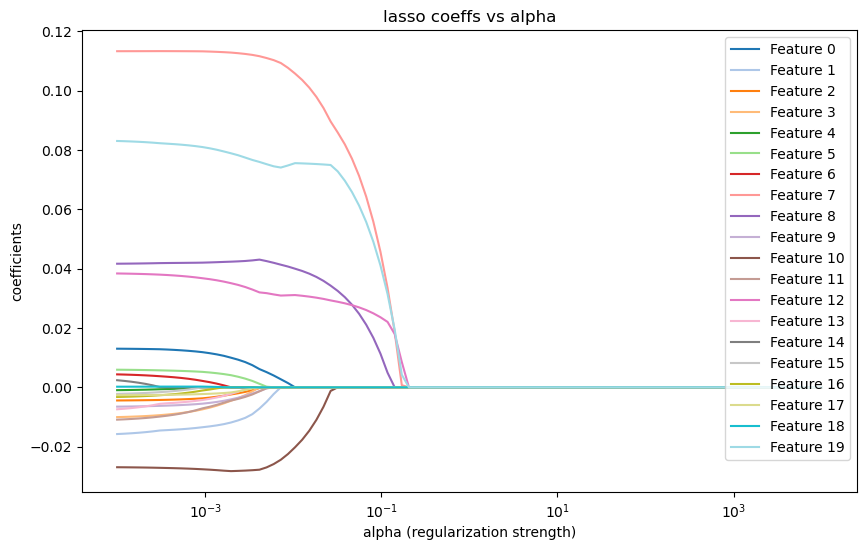

In [60]:
# because the color gradient is confusing, I'm going to rerun again. but this time, I'm dropping the first few IVs 
# that lasso killed, and running the lasso again on IVs that I'd like a closer look for

x_train2 = x_train[['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 
                    'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'cab_count', 
                    'country_id', 'largest_cab', 'lag_largest_parl', 'lag_largest_cab', 'country_dummy10', 
                    'country_dummy11', 'country_dummy12', 'country_dummy13', 'PC0']]

#print(x_train)
x_train2_scaled = scaler.fit_transform(x_train2)
#x_test_scaled = scaler.transform(x_test)

# initialize a range of alpha values for lasso (this is the parameter for regularization)
alphas = np.logspace(-4, 4, 100)

# store coefficients for different alphas
coefficients = []

for alpha in alphas:
    # initialize lasso regression with current alpha
    lasso = Lasso(alpha=alpha)

    # fit lasso on the training data
    lasso.fit(x_train2_scaled, y_train)

    # store coefficients for current alpha
    coefficients.append(lasso.coef_)

#columns_to_drop = ['cabinet_proportion']
#blah = x_train.drop(columns=columns_to_drop, inplace=False)

# plotting the coefficients vs alphas
plt.figure(figsize=(10, 6))
colors = cm.tab20(np.linspace(0, 1, x_train2.shape[1]))  # Using the tab20 colormap for vibrant and distinct colors
for i, col in zip(range(x_train2.shape[1]), colors):
    plt.plot(alphas, [coef[i] for coef in coefficients], color=col, label=f'Feature {i}')

plt.xscale('log')
plt.xlabel('alpha (regularization strength)')
plt.ylabel('coefficients')
plt.title('lasso coeffs vs alpha')
plt.legend(loc='upper right')  # Legend shows all features
plt.grid(False)
plt.show()


In [61]:
# keep prime_minister (Feature 8), cabinet_party (Feature 7), PC0 (Feature 19), and largest_cab (Feature 12), drop the rest

In [62]:
# step 20

# run a poly with my 4 IVs

x_train = x_train[['prime_minister', 'cabinet_party', 'PC0', 'largest_cab']]
x_test = x_test[['prime_minister', 'cabinet_party', 'PC0', 'largest_cab']]


# run a polynomial regression for degree 2 and get the equation

# fit polynomial regression of degree 2 on training data
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.transform(x_test)

model = LinearRegression()
model.fit(x_poly_train, y_train)

# predict on training and test sets
y_train_pred = model.predict(x_poly_train)
y_test_pred = model.predict(x_poly_test)

# calculate R^2 for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# get coefficients and intercept from the model
coefficients = model.coef_
intercept = model.intercept_
print("coefficients", coefficients)
print("intercept", intercept)
coeffs = coefficients

print("train R²:", train_r2)
print("test R²:", test_r2)
coeffs = coefficients

# calculate adjusted R² based on formula: R² = 1 - numerator/denominator 
# numerator is (1-R²)(N-1)
# denominator is N-p-1; N is total sample size (number of observations), while p is number of IVs
numerator = (1 - float(train_r2)) * (len(x_train) - 1)
denominator = (len(x_train) - float(np.size(coeffs)) - 1)
adjusted_train_r2 = 1 - numerator/denominator
print("adjusted train R²", adjusted_train_r2)

print("train MSE:", train_mse)
print("test MSE:", test_mse)

coefficients [ 0.01365587  0.12999414 -0.00034216 -0.02142168  0.01365587  0.01365587
 -0.0273946   0.0644325   0.12999414  0.10186187 -0.02142168  0.00050598
  0.00789608 -0.02142168]
intercept 0.0009841539817505018
train R²: 0.9175031433613254
test R²: 0.910428735947473
adjusted train R² 0.9134363969073063
train MSE: 0.004739435656778296
test MSE: 0.004585090556933435


In [63]:
# run the same poly again, but this time with standardization on the dataset (because I forgot to do it in the previous cell)


# standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit polynomial regression of degree 2 on standardized training data
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(x_train_scaled)
x_poly_test = poly.transform(x_test_scaled)

model = LinearRegression()
model.fit(x_poly_train, y_train)

# predict on training and test sets
y_train_pred = model.predict(x_poly_train)
y_test_pred = model.predict(x_poly_test)

# calculate R^2 for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# get coefficients and intercept from the model
coefficients = model.coef_
intercept = model.intercept_

print("coefficients", coefficients)
print("intercept", intercept)


print("train R²:", train_r2)
print("test R²:", test_r2)
coeffs = coefficients

# calculate adjusted R² based on formula: R² = 1 - numerator/denominator 
# numerator is (1-R²)(N-1)
# denominator is N-p-1; N is total sample size (number of observations), while p is number of IVs
numerator = (1 - float(train_r2)) * (len(x_train) - 1)
denominator = (len(x_train) - float(np.size(coeffs)) - 1)
adjusted_train_r2 = 1 - numerator/denominator
print("adjusted train R²", adjusted_train_r2)

print("train MSE:", train_mse)
print("test MSE:", test_mse)

coefficients [-2.70428889e+12  4.25008821e+12  8.12491987e-02 -6.42330240e+12
  1.18421760e+12  1.74373120e+11 -2.49726858e-02  7.64840048e-03
 -2.72450737e+12  1.02907834e-01  7.58419969e+12  6.12414517e-03
  7.45977603e-03 -1.34034551e+12]
intercept -1065741521045.3538
train R²: 0.906789703979508
test R²: 0.9027965943160292
adjusted train R² 0.902194830232019
train MSE: 0.005354921612022739
test MSE: 0.004975774565847162


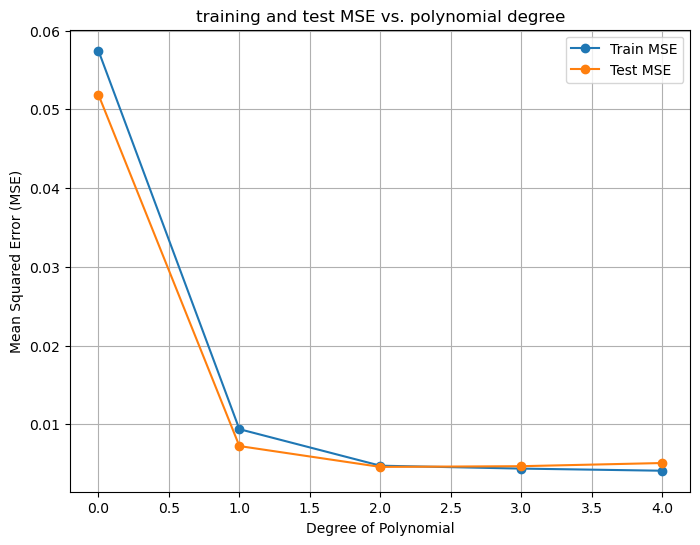

In [64]:
# step 21

# runing a train mse vs degree plot for potential polys with my new set of IVs

degrees = range(0, 5)  # try different polynomial degrees up to 6
train_mse = []
test_mse = []

for degree in degrees:
    # transform features to polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(x_train)
    X_poly_test = poly.transform(x_test)
    
    # fit linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_poly_train, y_train)
    
    # predict on training and test sets
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)
    
    # calculate the MSE for training and test sets
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    test_mse.append(mean_squared_error(y_test, y_test_pred))

# plot the results
plt.figure(figsize=(8, 6))
plt.plot(degrees, train_mse, label='Train MSE', marker='o')
plt.plot(degrees, test_mse, label='Test MSE', marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('training and test MSE vs. polynomial degree')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# step 22

# more feature selection 
# dropped prime_minister and largest_cab
# remaining IVs are PC0 and cabinet_party

# reasoning below: 

'''I went back and looked at my earlier VIF table and correlation matrix (10-12). 
prime_minister had a VIF of 5.271343e+00 in my earlier VIF table, while largest_cab had a VIF of 6.248973e+00, 
while cabinet_party had a VIF of 4.032470e+00. In short, both prime_minister and cabinet_party had VIF values 
that were higher than the ISLR’s threshold of 5 as an indicator for multicollinearity. I did not have a VIF 
measurement for PC0, because I ran PCA in step 16 after running VIF/my latent variable did not exist when I 
ran the VIF in step 10. Also, prime_minister was correlated with banzhaf at 0.67 and shapely at 0.68 and 
miw_proportion at 0.63 (three of the four variables used to create my latent variable). Also, largest_cab was 
correlated with banzhaf at 0.68 and shapley at 0.69 and splus at 0.71 and miw_proportion at 0.65 (the four 
variables used to create my latent variable PC0). Because it was highly probable that there was multicollinearity 
between PC0 and prime_minister and largest_cab, I decided to drop prime_minister and largest_cab. I did not drop 
cabinet_party because it had a VIF value of 4.032470e+00, which was under ISLR’s threshold of 5, and it had no 
correlation with any of the pivotality measuring IVs that were used to create my latent variable PC0.'''



'I went back and looked at my earlier VIF table and correlation matrix (10-12). \nprime_minister had a VIF of 5.271343e+00 in my earlier VIF table, while largest_cab had a VIF of 6.248973e+00, \nwhile cabinet_party had a VIF of 4.032470e+00. In short, both prime_minister and cabinet_party had VIF values \nthat were higher than the ISLR’s threshold of 5 as an indicator for multicollinearity. I did not have a VIF \nmeasurement for PC0, because I ran PCA in step 16 after running VIF/my latent variable did not exist when I \nran the VIF in step 10. Also, prime_minister was correlated with banzhaf at 0.67 and shapely at 0.68 and \nmiw_proportion at 0.63 (three of the four variables used to create my latent variable). Also, largest_cab was \ncorrelated with banzhaf at 0.68 and shapley at 0.69 and splus at 0.71 and miw_proportion at 0.65 (the four \nvariables used to create my latent variable PC0). Because it was highly probable that there was multicollinearity \nbetween PC0 and prime_ministe

In [66]:
# step 23

# reset x_train, x_test to our new subselection of IVs
# IVs that we are keeping (based on the feature selection in earlier cell)

x_train = x_train5[['PC0','cabinet_party']]
x_test = x_test5[['PC0','cabinet_party']]


In [67]:
# step 24

# this is my second poly attempt
# run a polynomial regression for degree 2 and get the equation

# standardize features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# fit polynomial regression of degree 2 on standardized training data
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(x_train_scaled)
x_poly_test = poly.transform(x_test_scaled)

model = LinearRegression()
model.fit(x_poly_train, y_train)

# predict on training and test sets
y_train_pred = model.predict(x_poly_train)
y_test_pred = model.predict(x_poly_test)

# calculate R^2 for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# get coefficients and intercept from the model
coefficients = model.coef_
intercept = model.intercept_

print("coefficients", coefficients)
print("intercept", intercept)


print("train R²:", train_r2)
print("test R²:", test_r2)
coeffs = coefficients

# calculate adjusted R² based on formula: R² = 1 - numerator/denominator 
# numerator is (1-R²)(N-1)
# denominator is N-p-1; N is total sample size (number of observations), while p is number of IVs
numerator = (1 - float(train_r2)) * (len(x_train) - 1)
denominator = (len(x_train) - float(np.size(coeffs)) - 1)
adjusted_train_r2 = 1 - numerator/denominator
print("adjusted train R²", adjusted_train_r2)

print("train MSE:", train_mse)
print("test MSE:", test_mse)


# note: according to sklearn documentation, if the input data set is two dimensional and we run degree 2 poly,
# the intepretation of .coef_ is [1, a, b, a^2, ab, b^2]

# [a, b] = ['PC0','cabinet_party']

# equation: cabinet_proportion = 8.50402461e-02 * PC0 + -6.70903266e+10 * cabinet_party + -3.17728009e-03 * PC0^2 + 
# + 9.79062350e-02 * PC0 * cabinet_party + 2.01926565e+11 * cabinet_party ^2

coefficients [ 8.50402461e-02 -6.70903266e+10 -3.17728009e-03  9.79062350e-02
  2.01926565e+11]
intercept -201926564546.0759
train R²: 0.9157664387359933
test R²: 0.9078263599442475
adjusted train R² 0.9143290059499181
train MSE: 0.0048392091531509135
test MSE: 0.004718304370137877


best alpha value: 0.03151435672216089
best test R²: -1
best train R²: -0.5052670209654602
best test mse: 0.019256574042692678
best train mse: 0.025935537126963653


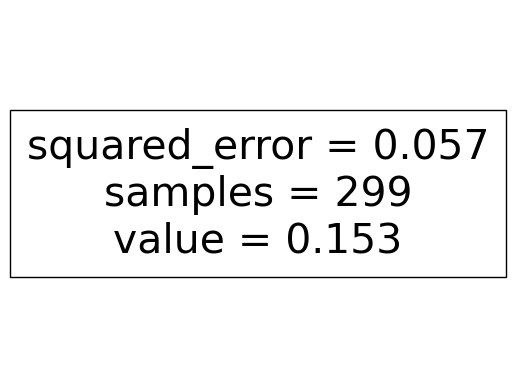

In [68]:
# step 25

# for funsies, let's just throw this all in a decision tree (only the 2 IVs I fed into the most recent poly)
# is going to overfit to optimize test R²; I just wanna see what it looks like (this tree will not make it to the write-up)

# has pruning (alpha is found thru cost complexity analysis)

# create a decision tree without pruning (commented out the plot because it was useful to look at, but makes my output messy)
tree_no_pruning = DecisionTreeRegressor()
tree_no_pruning.fit(x_train, y_train)
# calculate MSE for non-pruned tree
#y_pred_no_pruning = tree_no_pruning.predict(x_test)
#mse_no_pruning = mean_squared_error(y_test, y_pred_no_pruning)
#print(f"msewithout pruning: {mse_no_pruning:.2f}")

#plt.figure(figsize=(20, 6))
#plot_tree(tree_no_pruning, filled=True)
#plt.show()

# cost compexity pruning (finding an alpha value)
path = tree_no_pruning.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

best_alpha = None
best_test_r2 = -1
best_train_r2 = -1
best_test_mse = float('inf')
best_train_mse = float('inf')


# loop through ccp_alphas, fit trees, and store MSE and R² for each alpha
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=5, max_depth=100, ccp_alpha=alpha)
    pruned_tree.fit(x_train, y_train)
    
    # predict on test set and calculate MSE and R²
    y_pred_test = pruned_tree.predict(x_test[0:299])
    test_mse = mean_squared_error(y_test[0:299], y_pred_test)
    r2_test = r2_score(y_test[0:299], y_pred_test)
    r2_train = r2_score(y_train, y_pred_test)
    
    # predict on training set and calculate train MSE
    y_pred_train = pruned_tree.predict(x_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    
    # check if the current model is the best so far
    if r2_test > best_test_r2:
        best_alpha = alpha
        best__test_r2 = r2_test
        best_train_r2 = r2_train
        best_test_mse = test_mse
        best_train_mse = train_mse

# print the best tree
best_tree = DecisionTreeRegressor(ccp_alpha=best_alpha)
best_tree.fit(x_train, y_train)
plot_tree(best_tree, filled=True)

# performance indicators
# print the best alpha, R², test MSE, and train MSE for the best tree
print('best alpha value:', best_alpha)
print('best test R²:', best_test_r2)
print('best train R²:', best_train_r2)
print('best test mse:', best_test_mse)
print('best train mse:', best_train_mse)

train R²: 1.0
test R²: 0.848391306082719
train MSE: 0.0
test MSE: 0.007760743338639144
Index(['PC0', 'cabinet_party'], dtype='object')


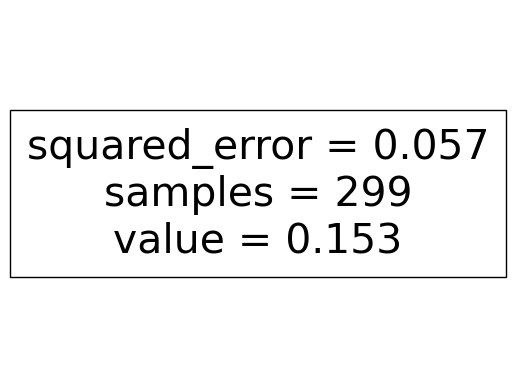

In [69]:
# for funsies, let's just throw this all in another decision tree (only the 2 IVs I fed into the most recent poly)
# this tree does not overfit to test R² as much as the previous one, but I use the same alpha value (found 
# through cost complexity analysis in ccp_alpha=alpha)

# initialize decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=4)
tree_reg.fit(x_train, y_train)

# predict on training and test sets
y_train_pred = tree_reg.predict(x_train)
y_test_pred = tree_reg.predict(x_test)

# calculate R² for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("train R²:", train_r2)
print("test R²:", test_r2)
print("train MSE:", train_mse)
print("test MSE:", test_mse)

# print Decision Tree
best_tree = DecisionTreeRegressor(ccp_alpha=best_alpha)
best_tree.fit(x_train, y_train)
plot_tree(best_tree, filled=True)

print(x_train.columns)


train R²: 1.0
test R²: 0.8855905896712042
train MSE: 6.183587781310189e-35
test MSE: 0.005856537947429855
largest_cab


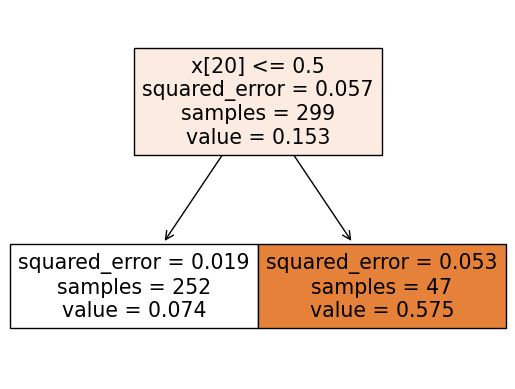

In [70]:
# step 26

# run another tree but with all possible 45 IVs from ind_vars (cabinet_seats and total_cabinet_size taken out)
# 44 IVs were from original data set, and the last IV in ind_vars is PC0

x_train = x_train7[ind_vars]
x_test = x_test7[ind_vars]
y_test = y_test7
y_train = y_train7

#print(x_train7.columns)

# all possible IVs:
# 45_IVs = ['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id',
       #'caretaker', 'cabinet_party', 'prime_minister', 'left_rightx', 'party_count', 'cab_count',
       #'country_id', 'election_id', 'seats_share', 'post_election', 'enpp',
       #'mingov', 'bicameral', 'largest_parl', 'largest_cab',
       #'lag_largest_parl', 'lag_largest_cab', 'seats_total',
       #'seats_proportion', 'W', 'B', 'B_star', 'C', 'D', 'E', 'country_dummy1',
       #'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5',
       #'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9',
       #'country_dummy10', 'country_dummy11', 'country_dummy12',
       #'country_dummy13', 'PC0']

# initialize decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

# predict on training and test sets
y_train_pred = tree_reg.predict(x_train)
y_test_pred = tree_reg.predict(x_test)

# calculate R² for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("train R²:", train_r2)
print("test R²:", test_r2)
print("train MSE:", train_mse)
print("test MSE:", test_mse)

# print Decision Tree
best_tree = DecisionTreeRegressor(ccp_alpha=best_alpha)
best_tree.fit(x_train, y_train)
plot_tree(best_tree, filled=True)
print(ind_vars[20])

In [71]:
# step 27

# running lasso again for feature selection for a tree, but this time so I can identify more IVs to use for a tree/not be 
# limited to only the IVs I feature-selected for the polys

from sklearn.linear_model import Lasso
import pandas as pd

# assuming X is your feature matrix and y is your target variable

# fit lasso regression model on training data
lasso = Lasso(alpha=0.001)  # you can adjust the alpha (regularization strength) as needed
lasso.fit(x_train6, y_train6)

# get the coefficients
coefficients = pd.Series(lasso.coef_, index=x_train6.columns)

# identify variables with zero coefficients (eliminated by lasso)
zero_coefficients = coefficients[coefficients == 0]
variables_zeroed = zero_coefficients.index.tolist()

print("variables with coefficients reduced to zero by lasso by this alpha:")
print(variables_zeroed)

variables_nonzeroed = []
for ind_variable in x_train6.columns:
    if ind_variable not in variables_zeroed:
        variables_nonzeroed.append(ind_variable)

print("variables with non-zero coefficients in lasso at this alpha:")
print(variables_nonzeroed)


variables with coefficients reduced to zero by lasso by this alpha:
['caretaker', 'seats_share', 'post_election', 'bicameral', 'lag_largest_parl', 'lag_largest_cab', 'seats_proportion', 'B', 'B_star', 'E', 'country_dummy1', 'country_dummy2', 'country_dummy3', 'country_dummy4', 'country_dummy5', 'country_dummy6', 'country_dummy7', 'country_dummy8', 'country_dummy9', 'country_dummy10', 'country_dummy11', 'country_dummy12', 'country_dummy13']
variables with non-zero coefficients in lasso at this alpha:
['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'cabinet_party', 'prime_minister', 'left_rightx', 'party_count', 'cab_count', 'country_id', 'election_id', 'enpp', 'mingov', 'largest_parl', 'largest_cab', 'seats_total', 'W', 'C', 'D', 'PC0']


train R²: 1.0
test R²: 0.8643132568382129
train MSE: 0.0
test MSE: 0.006945709780397034


[Text(0.5, 0.75, 'x[16] <= 0.5\nsquared_error = 0.057\nsamples = 299\nvalue = 0.153'),
 Text(0.25, 0.25, 'squared_error = 0.019\nsamples = 252\nvalue = 0.074'),
 Text(0.75, 0.25, 'squared_error = 0.053\nsamples = 47\nvalue = 0.575')]

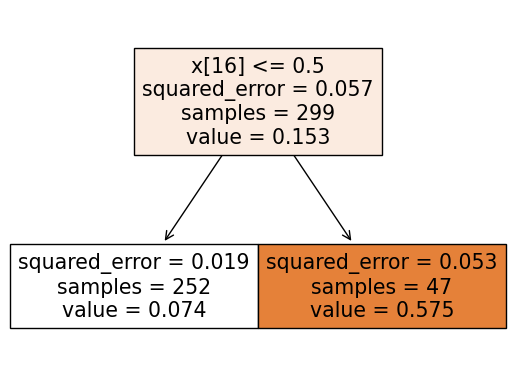

In [72]:
# step 28

# run last tree with feature selection done through lasso in previous cell; 
# all variables from variables_nonzeroed were fed in as IVs

# IVs with coefficients that were not zeroed through lasso when alpha = 0.001
IVs = ['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'cabinet_party', 
       'prime_minister', 'left_rightx', 'party_count', 'cab_count', 'country_id', 'election_id', 
       'enpp', 'mingov', 'largest_parl', 'largest_cab', 'seats_total', 'W', 'C', 'D', 'PC0']

x_train = x_train3[IVs]
x_test = x_test3[IVs]
y_test = y_test3
y_train = y_train3


# initialize decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

# predict on training and test sets
y_train_pred = tree_reg.predict(x_train)
y_test_pred = tree_reg.predict(x_test)

# calculate R² for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("train R²:", train_r2)
print("test R²:", test_r2)
print("train MSE:", train_mse)
print("test MSE:", test_mse)

# print Decision Tree
best_tree = DecisionTreeRegressor(ccp_alpha=best_alpha)
best_tree.fit(x_train, y_train)
plot_tree(best_tree, filled=True)

train R²: 1.0
test R²: 0.8895608931555545
train MSE: 0.0
test MSE: 0.005653300880198345


[Text(0.4, 0.8333333333333334, 'x[6] <= 0.5\nsquared_error = 0.057\nsamples = 299\nvalue = 0.153'),
 Text(0.2, 0.5, 'squared_error = 0.001\nsamples = 174\nvalue = 0.002'),
 Text(0.6, 0.5, 'x[19] <= 1.445\nsquared_error = 0.061\nsamples = 125\nvalue = 0.362'),
 Text(0.4, 0.16666666666666666, 'squared_error = 0.016\nsamples = 79\nvalue = 0.215'),
 Text(0.8, 0.16666666666666666, 'squared_error = 0.037\nsamples = 46\nvalue = 0.615')]

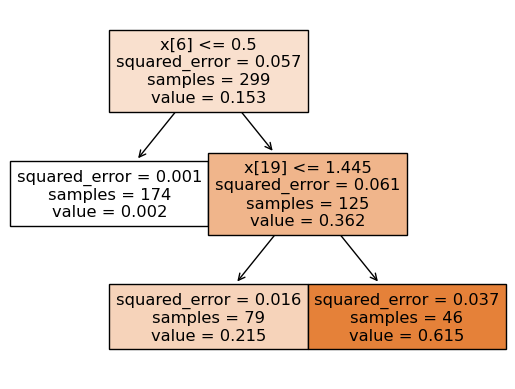

In [73]:
# step 29

# same IVs as previously, but largest_cab taken out. I'm forcing it to not choose largest_cab.
# run one last tree with feature selection done through lasso in previous cell

# IVs with coefficients that were not zeroed through lasso when alpha = 0.001, with largest_cab and prime_minister
# taken out because they were identified as multicollinear variables when I did feature selection for my second poly
IVs = ['seats', 'sq_pm', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'cabinet_party', 'left_rightx', 
       'party_count', 'cab_count', 'country_id', 'election_id', 
       'enpp', 'mingov', 'largest_parl', 'seats_total', 'W', 'C', 'D', 'PC0']

x_train = x_train3[IVs]
x_test = x_test3[IVs]
y_test = y_test3
y_train = y_train3


# initialize decisiont tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train)

# predict on training and test sets
y_train_pred = tree_reg.predict(x_train)
y_test_pred = tree_reg.predict(x_test)

# calculate R² for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# calculate MSE for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("train R²:", train_r2)
print("test R²:", test_r2)
print("train MSE:", train_mse)
print("test MSE:", test_mse)

# print Decision Tree
best_tree = DecisionTreeRegressor(ccp_alpha=0.01)
best_tree.fit(x_train, y_train)
plot_tree(best_tree, filled=True)

In [74]:
# step 30

print(x_train5)

# print out PC0 (for write-up)

latent_variable = np.array(x_train5['PC0'])  

# print values
print("values of latent variable:", latent_variable)

# calculate some summary statistics
print("min:", np.min(latent_variable))
print("max:", np.max(latent_variable))
print("mean:", np.mean(latent_variable))
print("std:", np.std(latent_variable))

# calculate some more summary statistics 
# calculate quartiles
quartiles = np.percentile(latent_variable, [25, 50, 75])
print("25th Percentile (Q1):", quartiles[0])
print("50th Percentile (Median / Q2):", quartiles[1])
print("75th Percentile (Q3):", quartiles[2])

     seats  sq_pm  election_year  miw_new  cabinet_id  party_id  caretaker  \
175     10    0.0           1987        3         279       228          0   
646     67    0.0           1993        4         572       104          0   
541      7    0.0           1992        7         176      1296          0   
482     35    0.0           1991       35         570      1378          1   
286     80    0.0           2001       42         256      1005          0   
..     ...    ...            ...      ...         ...       ...        ...   
351     14    0.0           2011        1         904       433          0   
452      7    0.0           2009        3         601       310          0   
436      5    0.0           2010        5         675      1594          1   
156      5    0.0           1998        5         749       357          0   
265     16    0.0           1992       16         176       242          0   

     cabinet_party  prime_minister  left_rightx  ...  country_d

In [75]:
# step 31

# run xgboost

# these IVs were feature-selected using the lasso also used for feature-selecting for the decision tree; I used an 
# alpha value of 0.001. I dropped PC0 before xgboost, I wanted to see how if xgboost could handle not having the principal 
# component I made.

IVs = ['seats', 'election_year', 'miw_new', 'cabinet_id', 'party_id', 'cabinet_party', 'left_rightx', 'cabinet_seats', 
       'total_cabinet_size', 'party_count', 'cab_count', 'country_id', 'election_id', 'seats_share', 'largest_cab', 
       'lag_largest_parl', 'seats_total', 'country_dummy5']

# create feature matrix 'X' and target vector 'y'
X = updated_data[IVs]
y = updated_data['cabinet_proportion']

# split the data into training and testing sets 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# create an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror')  # for regression task

# fit the model on the training data
model.fit(x_train, y_train)

# make predictions on training and test sets
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

# calculate train and test MSE
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# calculate R² for training and test sets
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# display performance metrics
print(f"train mse: {train_mse}")
print(f"test mse: {test_mse}")
print(f"train R²: {train_r2}")
print(f"test R²: {test_r2}")

print('xgb features', model.feature_importances_)


train mse: 4.0527830246743727e-07
test mse: 0.001159053603868567
train R²: 0.9999928892894258
test R²: 0.9776479323589424
xgb features [1.6447586e-03 2.4586164e-03 2.0341775e-03 7.8056299e-04 1.4226312e-02
 4.5657650e-02 6.6849445e-03 8.3557439e-01 3.9773140e-02 1.5028776e-03
 3.5707243e-02 7.8784797e-04 5.3225347e-04 9.7173452e-03 1.7053037e-05
 1.3226033e-03 1.5782720e-03 0.0000000e+00]
